# Anime Recommendation System

<br>

![Naruto](https://wallpaperscave.com/images/thumbs/download/1280x768/18/02-21/anime-naruto-19895.jpg "Naruto")


## Introduction

From anime [dataset](https://www.kaggle.com/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv), We create recommendation system witch use cluster technique.<br>
Recommended anime were extracted from characteristic of cluster.<br>
User was segmented by user anime rating history.

[myanimelist site](https://myanimelist.net/)


### Steps

- Preprocessing
- Visualization
- K-Mean clustering
- Characteristic of each cluster


### Libraries

Import all libraries we need for data mining.


In [1]:
# Basic libraries
from random import randint
from chernoff_faces import cface

# Import numpy, pandas and matplot libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

# Machine learning libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Finding spark in jupyter notebook
import findspark
findspark.init()

# Frequent pattern libraries
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import *

# Import HTML lib for changing direction of page
from IPython.display import HTML
from IPython.display import display
HTML('<style>.output{flex-direction:row;flex-wrap:wrap}</style>')

# Setup style of charts
plt.style.use('seaborn')
%config InlineBackend.figure_formats = {'png', 'retina'}


## Preprocessing

In this section, we are going to pre-process the data, so we will first clean the data and replace the missing values with valid values - The attribute mean for all samples belonging to the same class - and then remove the extra columns, and we will also combine the data sets. And sampling data to reduce data volume.


### Read anime dataset


In [2]:
# Read anime dataset from csv file
anime = pd.read_csv("../data/anime.csv")
# Show the first 3 records
anime.head(3)


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0


In [3]:
# Count of row and column
anime.shape


(17562, 35)

### Anime dataset reduction


In [4]:
# Remove extra columns from anime dateframe and then rename `MAL_ID` to `Anime_ID`,
# also set `Anime_ID` to index of dataframe
anime = (
    anime[
        [
            "MAL_ID",
            "Ranked",
            "Popularity",
            "Name",
            "Genres",
            "Type",
            "Source",
            "Rating",
            "Episodes",
            "Score",
            "Members",
            "Favorites",
        ]
    ]
    .rename(
        {
            "MAL_ID": "anime_id",
            "Ranked": "ranked",
            "Popularity": "popularity",
            "Name": "name",
            "Genres": "genres",
            "Type": "type",
            "Source": "source",
            "Rating": "rating",
            "Episodes": "episodes",
            "Score": "score",
            "Members": "members",
            "Favorites": "favorites",
        },
        axis=1,
    )
    .set_index("anime_id")
)


In [5]:
# Remove invalid row with `Unknown` ranked
anime = anime[(anime["ranked"] != "Unknown") & (anime["ranked"] != "0.0")]


### Anime dataset transaction


In [6]:
# Replace missing `Score` and `Episodes` with zero
anime["score"].replace("Unknown", 0.0, inplace=True)
anime["episodes"].replace("Unknown", 0, inplace=True)


In [7]:
# Change the `Ranked`, `Episodes` and `Score` columns to numeric for math operations,
# as well as sort the table by `Ranked`
anime = (
    anime.astype({"ranked": "float"})
    .astype({"ranked": "int", "episodes": "int", "score": "float"})
    .sort_values("ranked")
)


### Calculate mean for each type


In [8]:
# Calculate mean of `Score` and `Episodes` for each `Type`
group_by_type = anime.groupby("type")
print("✓ Mean of score for each type")
display(mean_scores := group_by_type["score"].mean().round(2))

print("\n✓ Mean of episodes for each type")
display(mean_episodes := group_by_type["episodes"].mean().round().astype(int))


✓ Mean of score for each type


type
Movie      4.42
Music      2.93
ONA        3.58
OVA        4.27
Special    5.14
TV         5.50
Name: score, dtype: float64


✓ Mean of episodes for each type


type
Movie       1
Music       1
ONA         9
OVA         2
Special     2
TV         33
Name: episodes, dtype: int32

### Handel missing values


In [9]:
# Replace zeroes `Score` with its own category mean
for index in mean_scores.index:
    anime["score"].mask(
        (anime["type"] == index) & (anime["score"] == 0.0),
        mean_scores[index],
        inplace=True,
    )


In [10]:
# Replace zeroes `Episodes` with its own category mean
for index in mean_episodes.index:
    anime["episodes"].mask(
        (anime["type"] == index) & (anime["episodes"] == 0),
        mean_episodes[index],
        inplace=True,
    )


### Write reduced anime dataset


In [11]:
# Wright anime dataset to csv file
anime.to_csv("../data/anime_reduce.csv")


### Display information of anime dataset


In [12]:
anime = pd.read_csv("../data/anime_reduce.csv")
anime.head()


,anime_id,ranked,popularity,name,genres,type,source,rating,episodes,score,members,favorites
0,5114,1,3,Fullmetal Alchemist: Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,Manga,R - 17+ (violence & profanity),64,9.19,2248456,183914
1,40028,2,119,Shingeki no Kyojin: The Final Season,"Action, Military, Mystery, Super Power, Drama,...",TV,Manga,R - 17+ (violence & profanity),16,9.17,733260,44862
2,9253,3,9,Steins;Gate,"Thriller, Sci-Fi",TV,Visual novel,PG-13 - Teens 13 or older,24,9.11,1771162,148452
3,38524,4,63,Shingeki no Kyojin Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Sho...",TV,Manga,R - 17+ (violence & profanity),10,9.10,1073626,40985
4,28977,5,329,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,Manga,PG-13 - Teens 13 or older,51,9.10,404121,11868


In [13]:
anime.shape


(15798, 12)

In [14]:
anime.describe().round(2)


,anime_id,ranked,popularity,episodes,score,members,favorites
count,15798.00,15798.00,15798.00,15798.00,15798.00,15798.00,15798.00
mean,21601.96,7896.21,8884.46,12.46,5.88,37752.95,503.86
std,14671.07,4556.74,5229.80,49.12,1.36,131649.10,4281.61
min,1.00,1.00,1.00,1.00,1.85,25.00,0.00
25%,6514.00,3946.50,4084.00,1.00,5.14,298.00,0.00
50%,23350.00,7896.00,9195.50,2.00,6.08,1737.00,2.00
75%,35454.75,11845.75,13518.75,12.00,6.92,15706.00,31.00
max,48480.00,15780.00,17560.00,3057.00,9.19,2589552.00,183914.00


### Read rating dataset


In [15]:
rating = pd.read_csv("../data/rating.csv").rename({"rating": "user_rating"}, axis=1)
rating.head(10)


,user_id,anime_id,user_rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
5,0,431,8
6,0,578,10
7,0,433,6
8,0,1571,10
9,0,121,9


In [16]:
rating.shape


(57633278, 3)

In [17]:
rating["user_rating"].describe().round(2)


count    57633278.00
mean            7.51
std             1.70
min             1.00
25%             7.00
50%             8.00
75%             9.00
max            10.00
Name: user_rating, dtype: float64

### Definition of Like

Because of many users, many differences criteria for rating anime.
Then, We decide to find rating mean of each user.
Anime which got rating higher than user rating mean will assign as like

```
rating['user_rating'] > rating['mean_rating'] => User like this anime
```

![like](https://www.vhv.rs/dpng/f/561-5618483_instagram-likes-png.png "like")


In [18]:
# User 922 has a low in rating mean
rating[rating["user_id"] == 922]["user_rating"].mean().round(3)


1.0

In [19]:
# User 99 has a middle in rating mean
rating[rating["user_id"] == 105]["user_rating"].mean().round(3)


5.0

In [20]:
# User 12 has a hight in rating mean
rating[rating["user_id"] == 12]["user_rating"].mean().round(3)


10.0

### Calculate mean rating per user


In [21]:
mean_rating_per_user = rating.groupby(["user_id"]).mean().reset_index()
mean_rating_per_user["mean_rating"] = mean_rating_per_user["user_rating"]

mean_rating_per_user.drop(["anime_id", "user_rating"], axis=1, inplace=True)


In [22]:
mean_rating_per_user.head(10)


,user_id,mean_rating
0,0,7.400000
1,1,8.058252
2,2,8.333333
3,3,7.603175
4,4,7.652542
5,5,8.162791
6,6,7.073955
7,7,7.908046
8,8,7.611111
9,10,7.750000


### Merge mean rating to rating data frame


In [23]:
rating = pd.merge(rating, mean_rating_per_user, on=["user_id", "user_id"])


In [24]:
rating.head()


,user_id,anime_id,user_rating,mean_rating
0,0,430,9,7.4
1,0,1004,5,7.4
2,0,3010,7,7.4
3,0,570,7,7.4
4,0,2762,9,7.4


In [25]:
# Drop anime's user don't liked
rating = rating.drop(rating[rating["user_rating"] < rating["mean_rating"]].index)


In [26]:
# user 922 favorite only one anime
rating[rating["user_id"] == 922].head()


,user_id,anime_id,user_rating,mean_rating
149818,922,16870,1,1.0


In [27]:
# user 105 favorite only one anime
rating[rating["user_id"] == 105].head()


,user_id,anime_id,user_rating,mean_rating
13008,105,249,5,5.0


In [28]:
rating[rating["user_id"] == 12].head()


,user_id,anime_id,user_rating,mean_rating
1246,12,31964,10,10.0
1247,12,16335,10,10.0
1248,12,11021,10,10.0
1249,12,35062,10,10.0
1250,12,20785,10,10.0


In [29]:
rating.shape


(30706635, 4)

In [30]:
# Number of users
len(rating["user_id"].unique())


310059

### Combine two datasets

In this section, we decide to reduce size of dataset, because of running time and memory


In [31]:
# Merge anime and rating data frame
mergedata = pd.merge(anime, rating, on=["anime_id", "anime_id"])
# Choice record with User_ID lower than equal 25000, This is a random choice
mergedata = mergedata[mergedata["user_id"] <= 25000]
mergedata.head()


,anime_id,ranked,popularity,name,genres,type,source,rating,episodes,score,members,favorites,user_id,user_rating,mean_rating
0,5114,1,3,Fullmetal Alchemist: Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,Manga,R - 17+ (violence & profanity),64,9.19,2248456,183914,1,10,8.058252
1,5114,1,3,Fullmetal Alchemist: Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,Manga,R - 17+ (violence & profanity),64,9.19,2248456,183914,6,10,7.073955
2,5114,1,3,Fullmetal Alchemist: Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,Manga,R - 17+ (violence & profanity),64,9.19,2248456,183914,7,10,7.908046
3,5114,1,3,Fullmetal Alchemist: Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,Manga,R - 17+ (violence & profanity),64,9.19,2248456,183914,11,10,8.503106
4,5114,1,3,Fullmetal Alchemist: Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,Manga,R - 17+ (violence & profanity),64,9.19,2248456,183914,12,10,10.000000


In [32]:
# Count of anime in mergedata
len(mergedata["anime_id"].unique())


11411

In [33]:
# Count of anime in actual dataset
len(anime["anime_id"].unique())


15798

### Write merge dataset


In [34]:
mergedata.to_csv('../data/mergedata.csv')


### Create Crosstable

Show detail of anime which each user like


In [35]:
mergedata = pd.read_csv("../data/mergedata.csv")
user_anime = pd.crosstab(mergedata["user_id"], mergedata["name"])
user_anime.columns.name = None
user_anime.index.name = None

user_anime.head(10)


,"""0""","""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Calpis"" Hakkou Monogatari","""Eiji""","""Eiyuu"" Kaitai","""Kiss Dekiru Gyoza"" x Mameshiba Movie","""Parade"" de Satie","""R100"" x Mameshiba Original Manners",...,s.CRY.ed Alteration I: Tao,s.CRY.ed Alteration II: Quan,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,ēlDLIVE,◯
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
user_anime.shape


(21804, 11409)

### Principal Component Analysis (PCA)

Principal Component Analysis converts our original variables to a new set of variables,
which are a linear combination of the original set of variables.
Main goal is to reduce dimension of data for clustering and visualize

[wikipedia](<https://en.wikipedia.org/wiki/Principal_component_analysis#:~:text=Principal%20component%20analysis%20(PCA)%20is,components%20and%20ignoring%20the%20rest.>)


In [37]:
pca = PCA(n_components=3)
pca.fit(user_anime)
pca_samples = pca.transform(user_anime)


In [38]:
ps = pd.DataFrame(pca_samples)
ps.head()


,0,1,2
0,-2.461742,0.477328,-0.081578
1,-1.083951,-1.401628,-1.014477
2,-1.693449,-0.630825,-0.298041
3,3.778695,0.226784,1.138751
4,-1.802398,1.464769,0.436394


In [39]:
ps.shape


(21804, 3)

## Visualization

In this section, we use a variety of graphs to display the data so that we can better understanding


### Data points in 3D PCA axis


In [40]:
to_cluster = pd.DataFrame(ps[[0, 1, 2]])


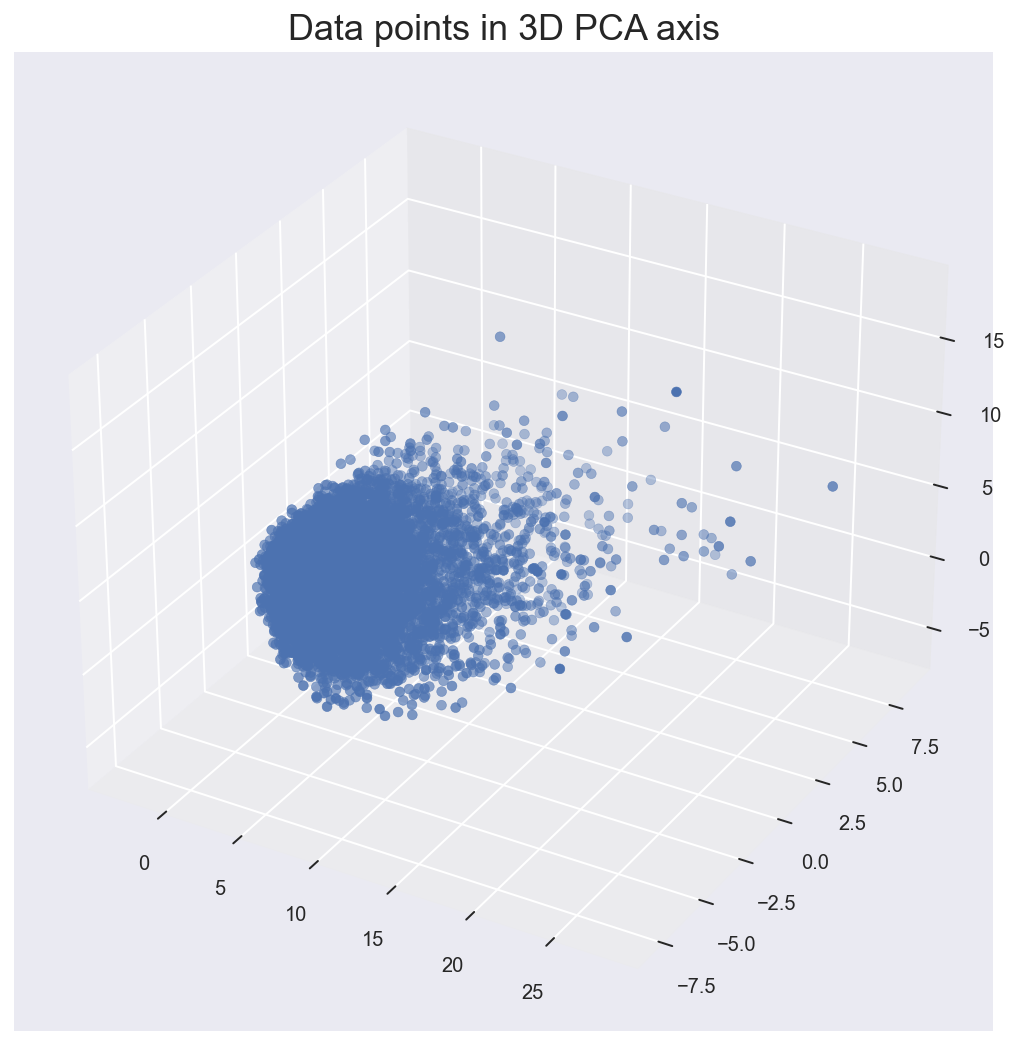

In [41]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection="3d")
ax.scatter(to_cluster[0], to_cluster[2], to_cluster[1], s=24)

plt.title("Data points in 3D PCA axis", fontsize=18)
plt.savefig("../charts/Data_points_in_3D_PCA_axis.png")
plt.show()


### Data points in 2D PCA axis


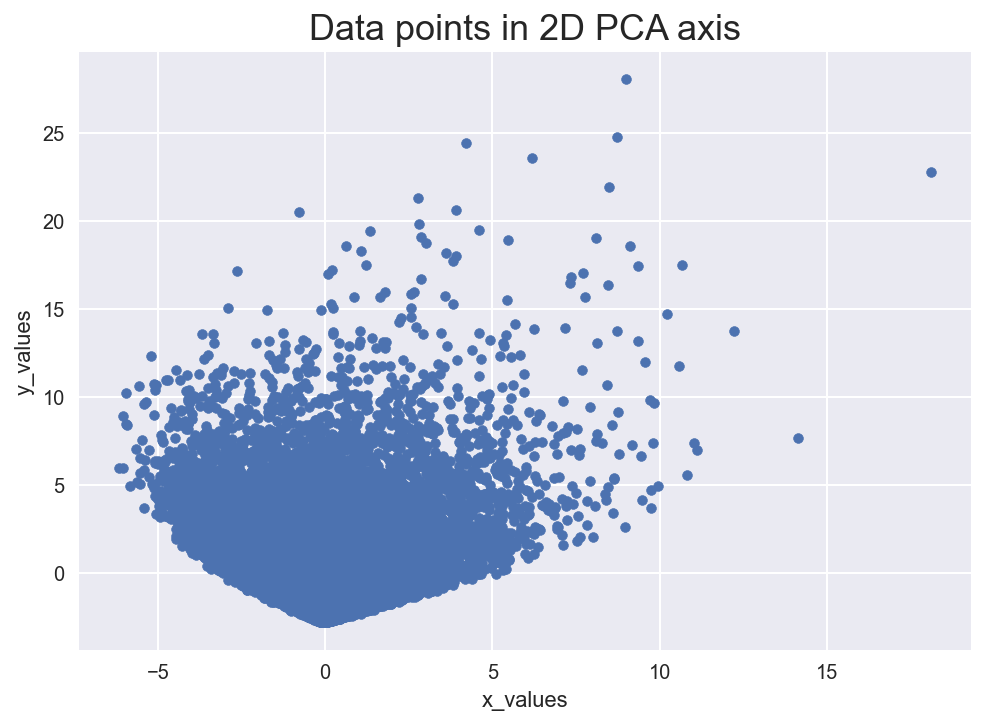

In [42]:
plt.scatter(to_cluster[1], to_cluster[0], s=24)
plt.xlabel("x_values")
plt.ylabel("y_values")
plt.title("Data points in 2D PCA axis", fontsize=18)
plt.savefig("../charts/Data_points_in_2D_PCA_axis.png")
plt.show()


### Chernoff faces

Display multivariate data in the shape of a human face. The individual parts, such as eyes, ears, mouth and nose represent values of the variables by their shape, size, placement and orientation [(wikipedia)](https://en.wikipedia.org/wiki/Chernoff_face)


In [43]:
# Reduce dimension for face attributes
pca = PCA(n_components=17)
pca.fit(user_anime)
pca_samples = pca.transform(user_anime)
ps = pd.DataFrame(pca_samples)
ps.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-2.461742,0.477327,-0.081578,0.064732,0.634798,0.142396,-0.051592,0.269147,-0.324508,-0.142589,0.113462,-0.245301,-0.565451,0.133959,-0.538926,-0.205612,0.021235
1,-1.083951,-1.401628,-1.014476,0.235317,-0.484953,0.098983,-1.004047,0.046567,0.459869,0.146468,0.718675,0.356861,0.807967,-0.057999,-0.275366,0.364260,0.360791
2,-1.693449,-0.630825,-0.298040,0.511194,-0.784856,0.568464,0.385865,-0.590062,0.612352,-0.411691,-0.189001,0.241942,0.175324,-0.141344,0.211314,0.080413,0.156759
3,3.778695,0.226784,1.138750,-1.648948,-0.991642,-1.601837,1.068610,-0.782450,-1.796181,-0.444752,-0.452496,-0.774258,0.586723,-0.709391,1.154184,-0.719425,-0.100087
4,-1.802398,1.464768,0.436394,0.679526,0.561298,-0.313808,-1.640556,-0.554039,-0.152285,0.861153,-0.331548,-0.356287,-0.692186,0.140269,0.834920,-0.020511,0.596688


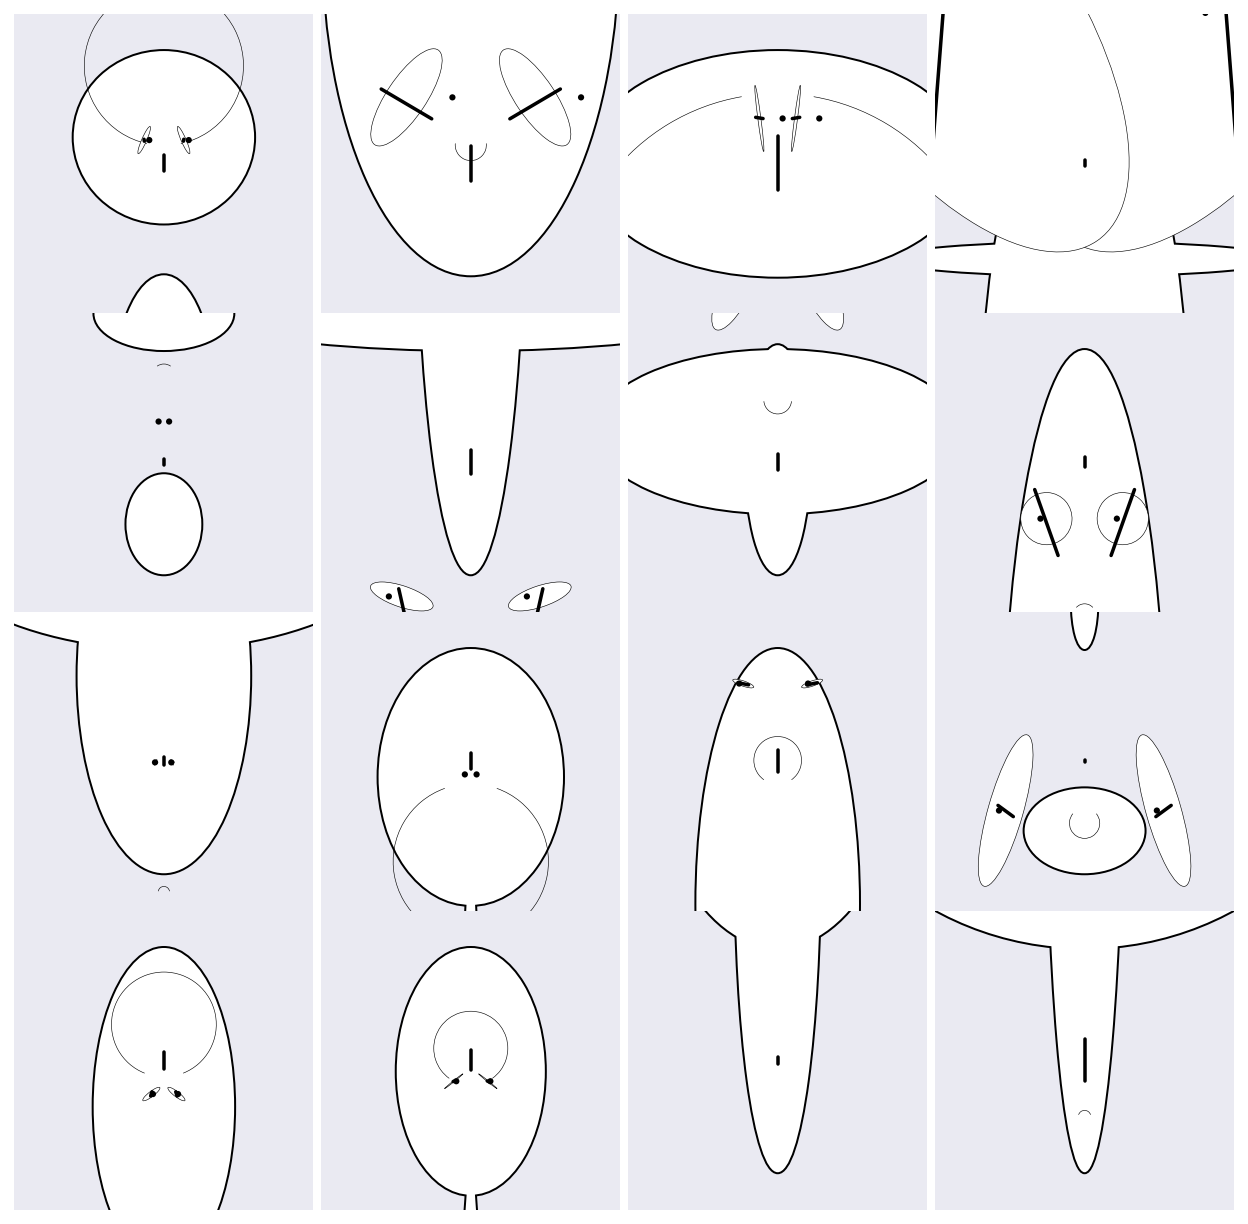

In [44]:
# Change size of figure
fig = plt.figure(figsize=(11, 11))

# Create sixteen face by random selection
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, aspect="equal")
    cface(ax, 0.9, *ps.iloc[randint(0, 21804), :])
    ax.axis([-1.2, 1.2, -1.2, 1.2])
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(hspace=0, wspace=0)
plt.savefig("../charts/Chernoff_faces.png", bbox_inches="tight")
plt.show()


### Box plots


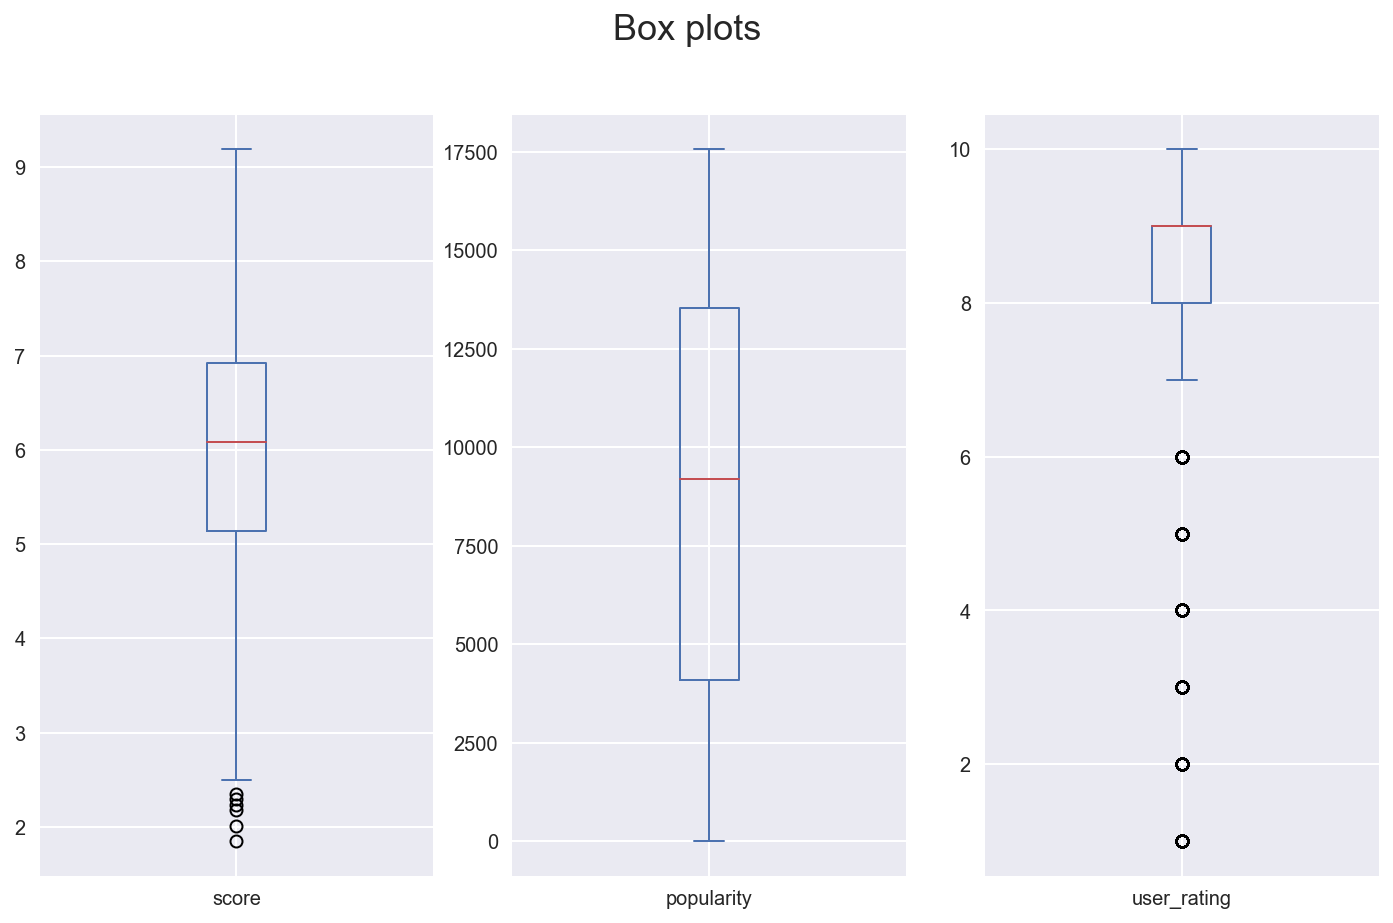

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12, 7))
fig.suptitle("Box plots", fontsize=18)

anime["score"].plot.box(ax=axes[0])
anime["popularity"].plot.box(ax=axes[1])
rating["user_rating"].plot.box(ax=axes[2])

plt.savefig("../charts/Box_plots.png")
plt.show()


### Score histogram


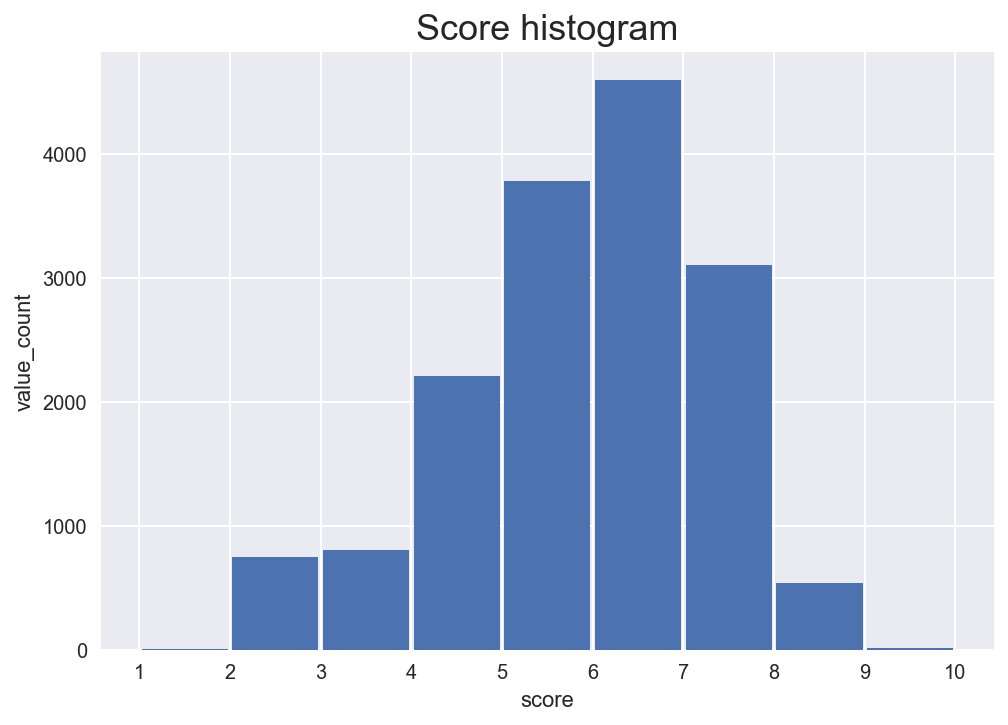

In [46]:
data = anime["score"].values
bins = np.arange(1, 11)
plt.hist(data, bins, histtype="bar", rwidth=0.95)

plt.title("Score histogram", fontsize=18)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel("score")
plt.ylabel("value_count")

plt.savefig("../charts/Score_histogram.png")
plt.show()


### Pixel-Oriented Visualization

Pixel plots are the representation of a 2-dimension data set. In these plots, each pixel refers to a different value in a data set


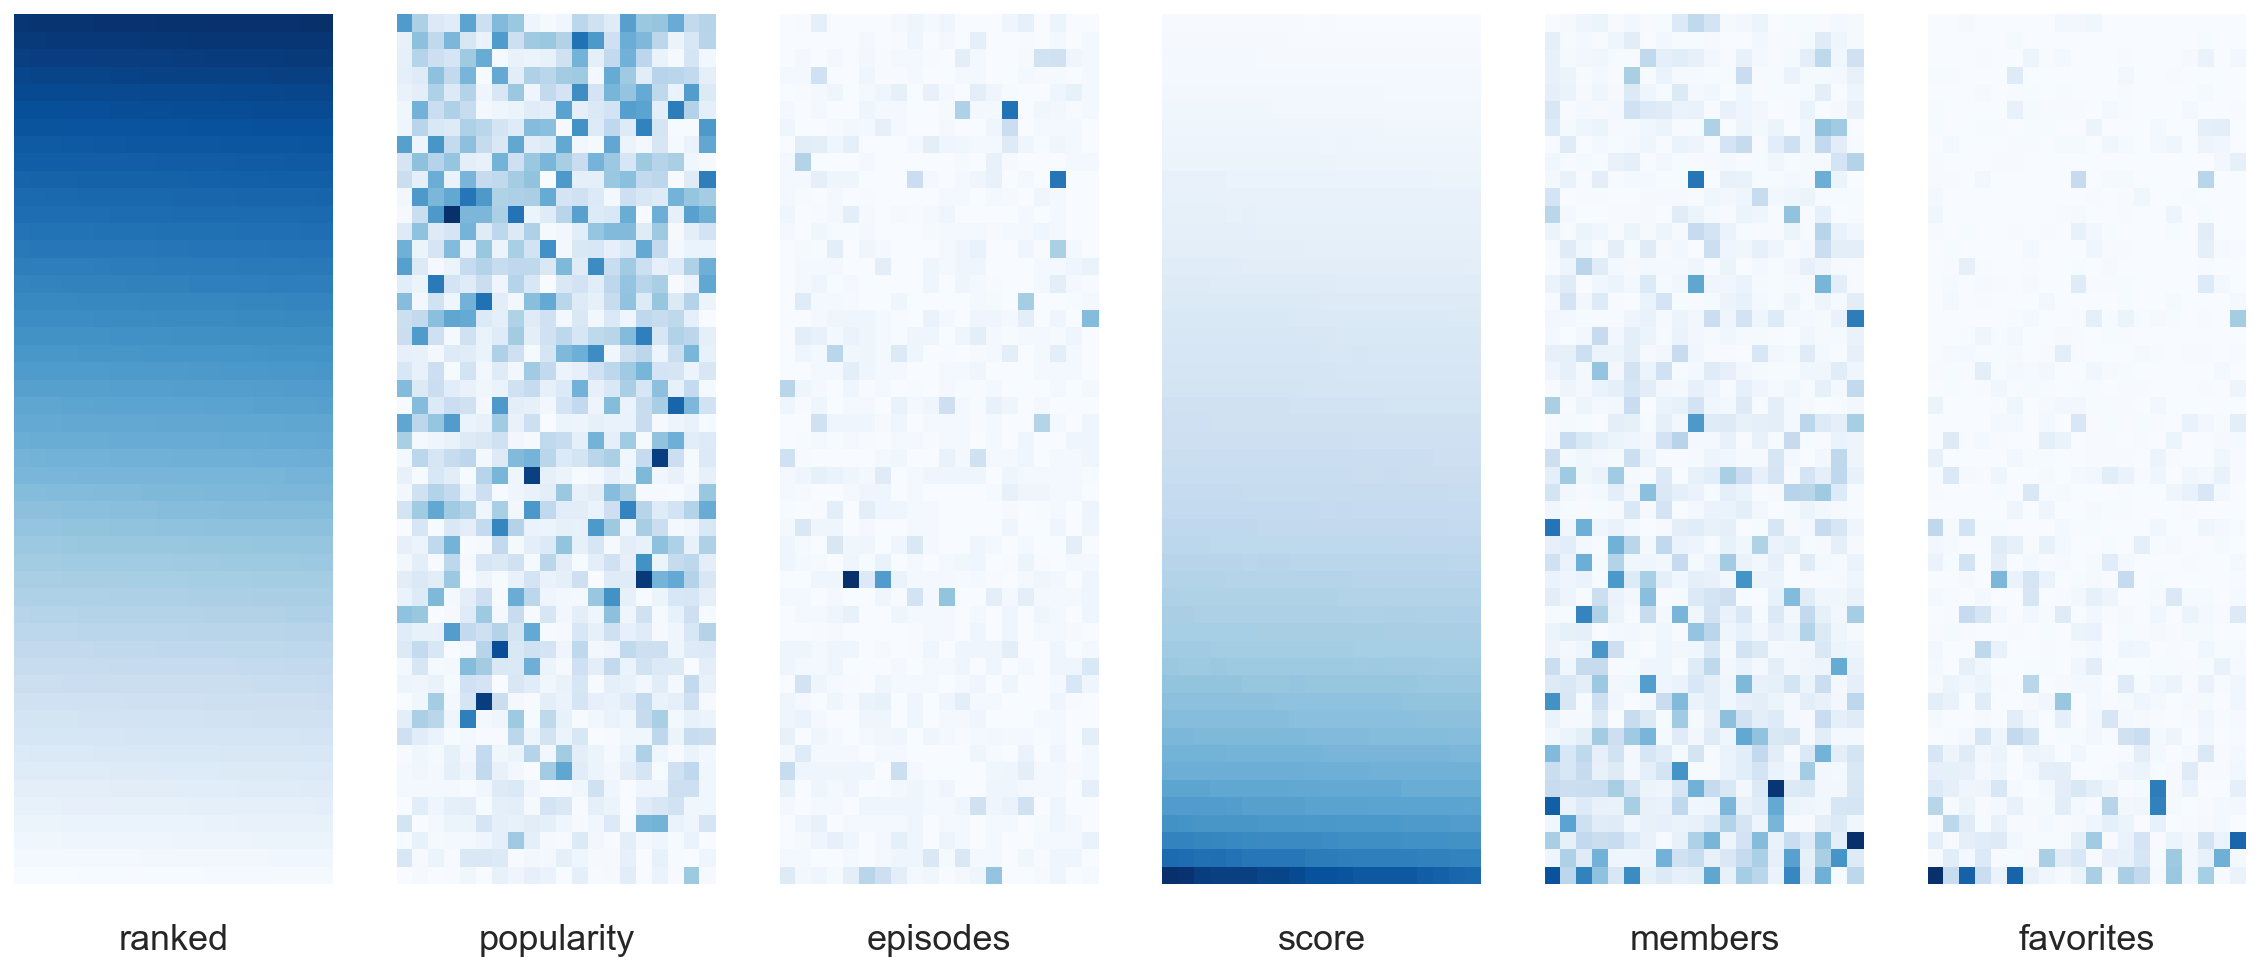

In [47]:
# Select first thousand data
head_anime = anime.head(1000)
columns = ["ranked", "popularity", "episodes", "score", "members", "favorites"]

# Creating a plot
fig, axes = plt.subplots(1, 6, figsize=(20, 8))

index = 0
for ax in axes:
    # plotting a plot
    data = head_anime[columns[index]].values.reshape((50, 20))
    ax.grid(False)
    ax.pcolor(data, cmap="Blues")

    # Customizing plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(columns[index], fontsize=18, labelpad=20)

    index += 1

# Save a plot
plt.savefig("../charts/Pixel_oriented.png")

# Show plot
plt.show()


### Score quantile plot

In statistics, a Q–Q (quantile-quantile) plot is a probability plot, which is a graphical method for comparing two probability distributions by plotting their quantiles against each other.


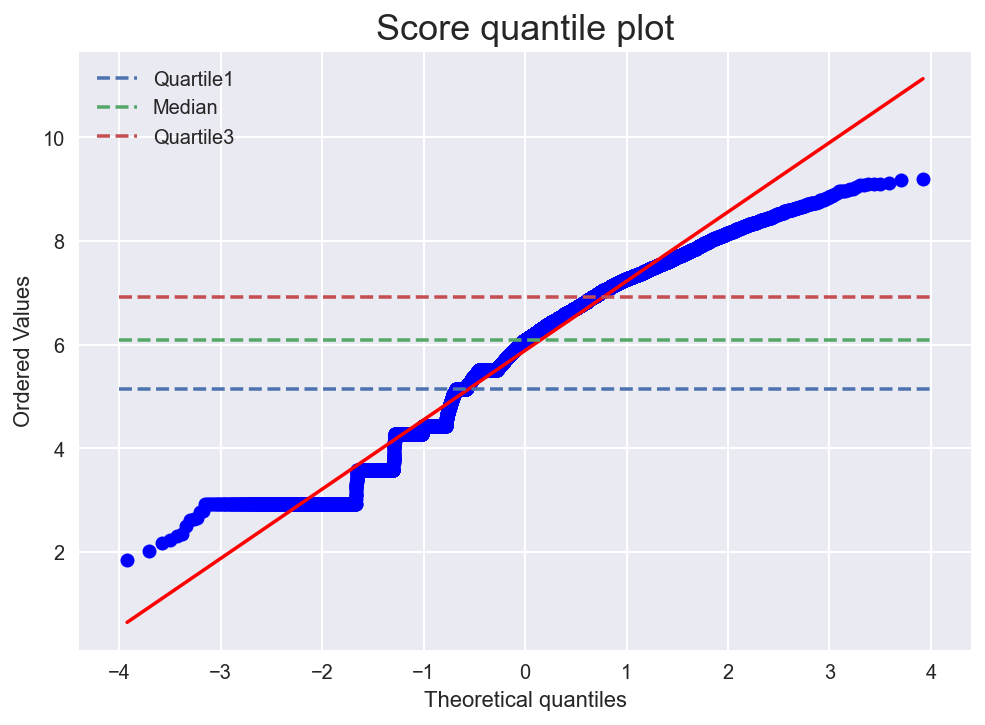

In [48]:
data = anime["score"]
fig, ax = plt.subplots(1, 1)

# Create quantile plot
stats.probplot(data, dist="norm", plot=ax)

# Calculate quantiles
median = data.median()
percent_25 = data.quantile(0.25)
percent_75 = data.quantile(0.75)

# Guide lines
plt.plot([-4, 4], [percent_25, percent_25], linestyle="dashed", label="Quartile1")
plt.plot([-4, 4], [median, median], linestyle="dashed", label="Median")
plt.plot([-4, 4], [percent_75, percent_75], linestyle="dashed", label="Quartile3")

# Customizing plot
plt.title("Score quantile plot", fontsize=18)
plt.legend()

plt.savefig("../charts/Score_quantile_plot.png")
plt.show()


### Scatter plot matrices

Provides a first look at data to see clusters of points, outliers, etc


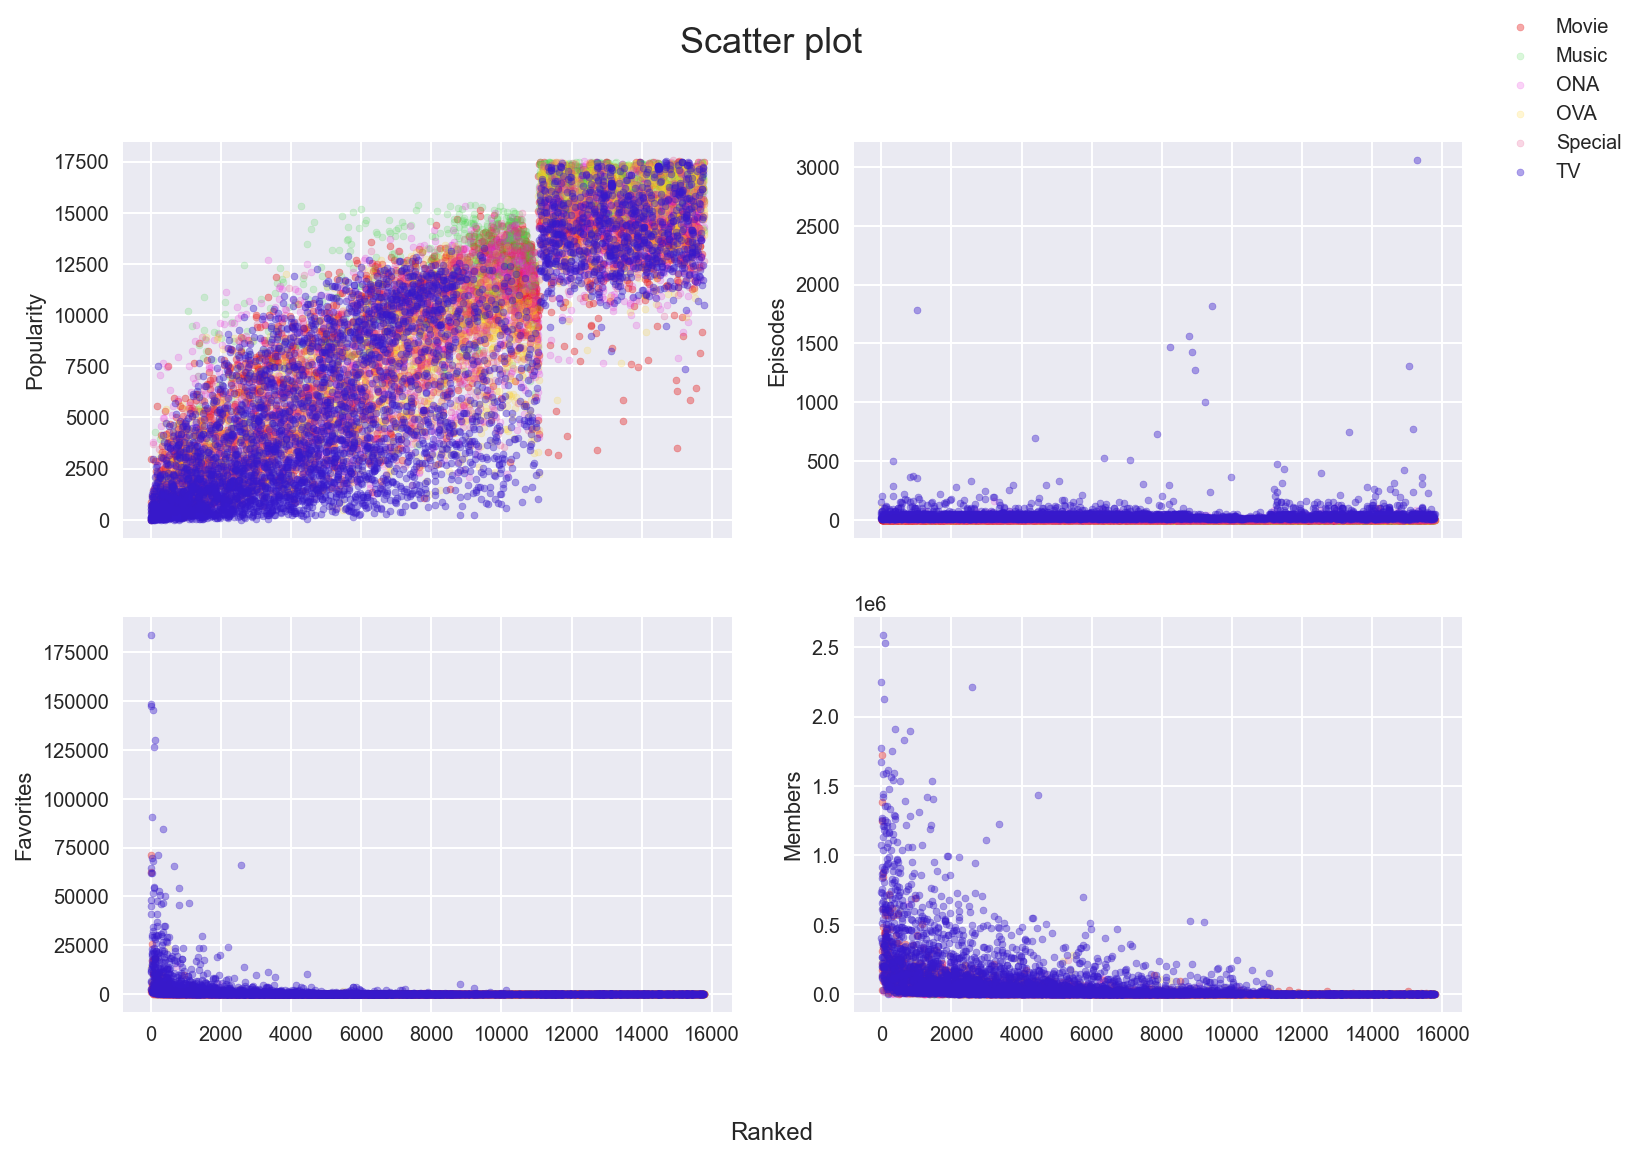

In [49]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 8))
fig.suptitle("Scatter plot", fontsize=18)
fig.supxlabel("Ranked")

group_setting = {
    # Type  marker   color   alpha
    "Movie": ["X", "#E72626", 0.4],
    "Music": ["^", "#48DA4B", 0.2],
    "ONA": [".", "#E820D7", 0.2],
    "OVA": ["*", "#FFD323", 0.2],
    "Special": [",", "#E4337A", 0.2],
    "TV": ["+", "#3719CC", 0.4],
}

# plotting a plot
for name in group_by_type.groups:
    data = group_by_type.get_group(name)
    color = group_setting[name][1]
    alpha = group_setting[name][2]

    axes[0, 0].scatter(data["ranked"], data["popularity"], marker=".", color=color, alpha=alpha, label=name)
    axes[0, 1].scatter(data["ranked"], data["episodes"], marker=".", color=color, alpha=alpha)
    axes[1, 0].scatter(data["ranked"], data["favorites"], marker=".", color=color, alpha=alpha)
    axes[1, 1].scatter(data["ranked"], data["members"], marker=".", color=color, alpha=alpha )

    # Customizing plot
    axes[0, 0].set_ylabel("Popularity")
    axes[0, 1].set_ylabel("Episodes")
    axes[1, 0].set_ylabel("Favorites")
    axes[1, 1].set_ylabel("Members")

fig.legend()
plt.savefig("../charts/Scatter_plot_matrices.png")
plt.show()


### Anime types


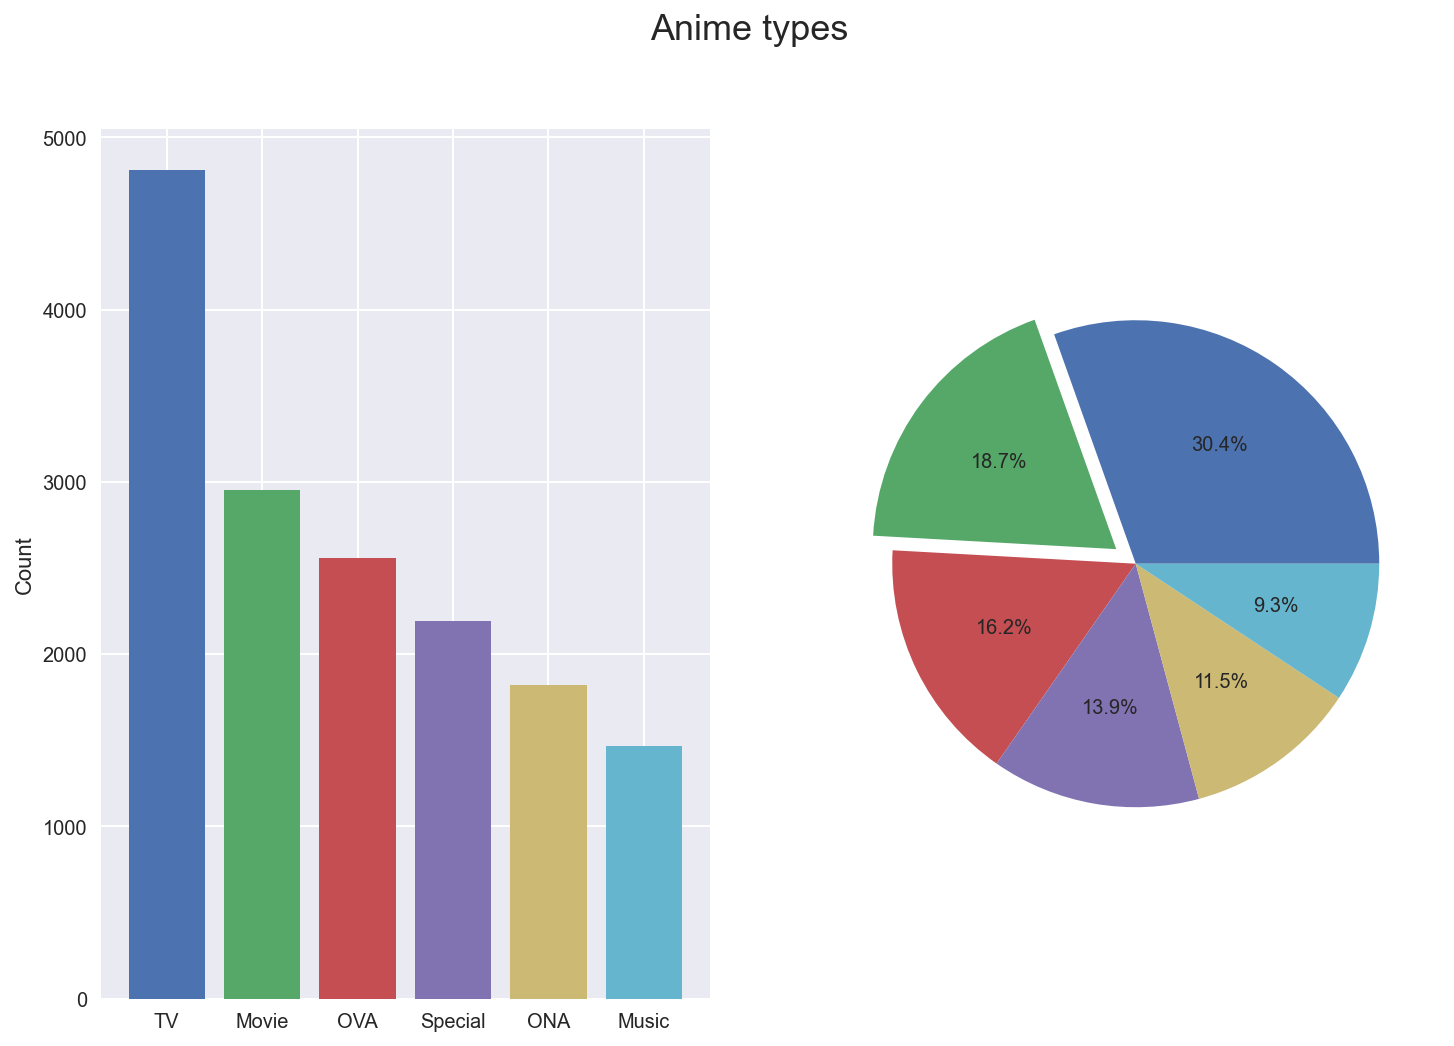

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle("Anime types", fontsize=18)

# Bar chart
data = anime["type"].value_counts()
for i in data.index:
    axes[0].bar(i, data[i])

axes[0].set_ylabel("Count")

# Pie chart
axes[1].pie(data, explode=(0, 0.1, 0, 0, 0, 0), autopct="%1.1f%%")

plt.savefig("../charts/Anime_types.png")
plt.show()


### Anime sources


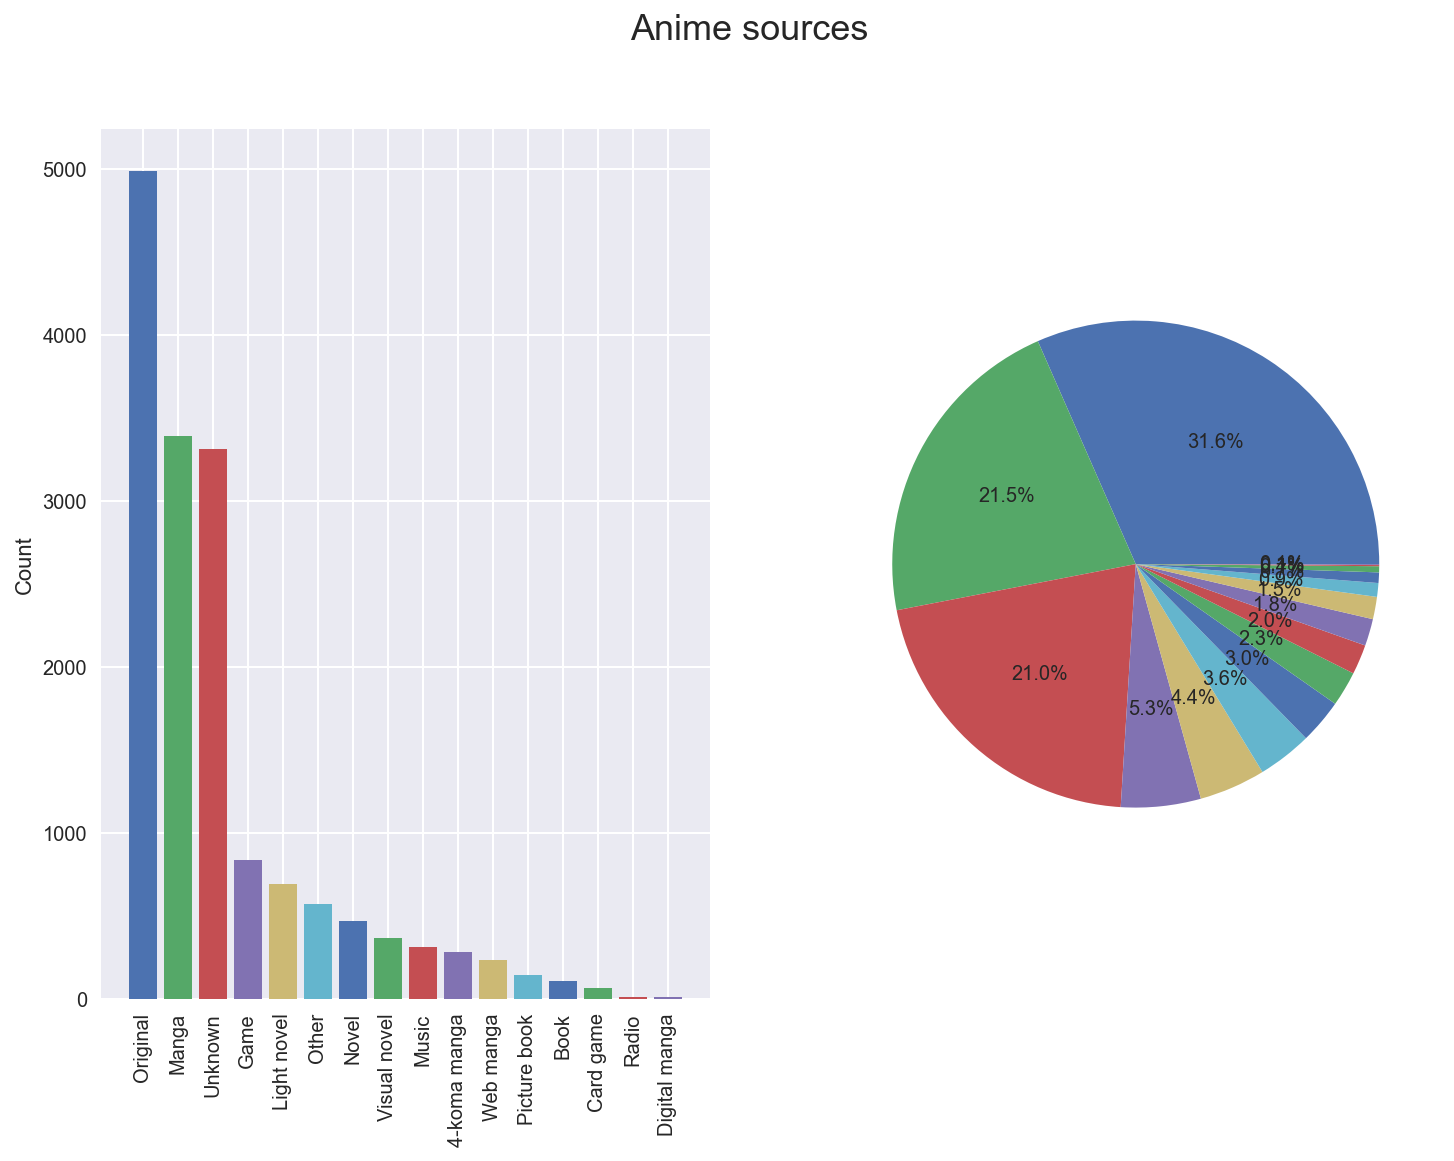

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle("Anime sources", fontsize=18)

# Bar chart
data = anime["source"].value_counts()
for i in data.index:
    axes[0].bar(i, data[i])

axes[0].tick_params(axis="x", rotation=90)
axes[0].set_ylabel("Count")

# Pie chart
axes[1].pie(data, autopct="%1.1f%%")

plt.savefig("../charts/Anime_sources.png")
plt.show()


### Anime ratings


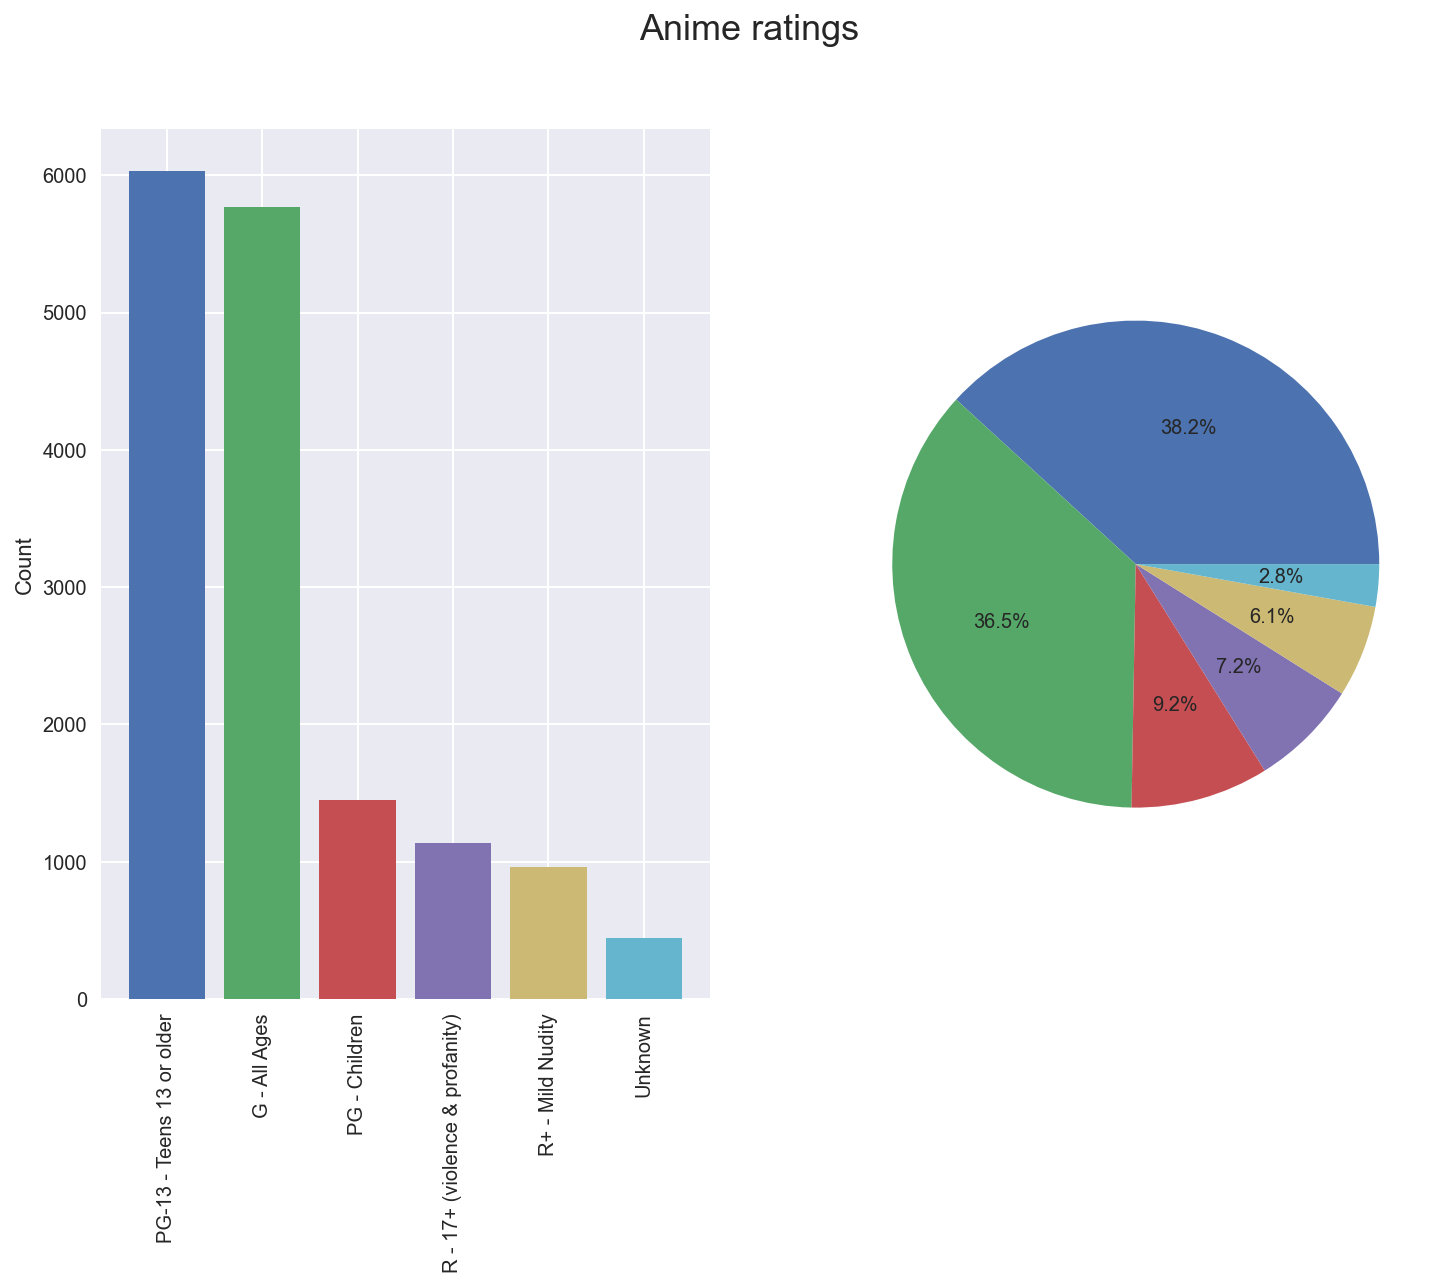

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle("Anime ratings", fontsize=18)

# Bar chart
data = anime["rating"].value_counts()
for i in data.index:
    axes[0].bar(i, data[i])

axes[0].tick_params(axis="x", rotation=90)
axes[0].set_ylabel("Count")

# Pie chart
axes[1].pie(data, autopct="%1.1f%%")

plt.savefig("../charts/Anime_ratings.png")
plt.show()


## Frequent Pattern Mining

Now, to find repetitive favorite anime's, we can use frequent patterns, find patterns and use them to predict what anime each user may watch.
Here we use the Spark library and FPGrowth algorithm and its guide, which is as follows:

- `minSupport`: the minimum support for an itemset to be identified as frequent. For example, if an item appears 3 out of 5 transactions, it has a support of 3/5=0.6.
- `minConfidence`: minimum confidence for generating Association Rule. Confidence is an indication of how often an association rule has been found to be true. For example, if in the transactions itemset X appears 4 times, X and Y co-occur only 2 times, the confidence for the rule `X => Y` is then 2/4 = 0.5. The parameter will not affect the mining for frequent itemsets, but specify the minimum confidence for generating.
- `association` rules from frequent itemsets.
  numPartitions: the number of partitions used to distribute the work. By default the param is not set, and number of partitions of the input dataset is used.


### Initialize Spark Library


In [53]:
spark = (
    SparkSession.builder.master("local")
    .appName("anime_recommendation_system")
    .getOrCreate()
)
sc = spark.sparkContext


In [54]:
# Create a map file
map_file = anime[["anime_id", "name"]]
map_file.set_index("anime_id", inplace=True)
map_file.to_csv("../data/frequent-pattern/map_file.csv")


### Prepare Data


We create a itemset for each user whose favorite anime is in these baskets.


In [55]:
# Group rows with user_id and then convert anime_id to list
df = mergedata.groupby("user_id")["anime_id"].apply(list)
# Write to csv file
df.to_csv("../data/frequent-pattern/itemset.csv")
df


user_id
0        [199, 164, 431, 578, 2236, 121, 2034, 2762, 15...
1        [5114, 9253, 11061, 28851, 32281, 199, 19, 232...
2        [9253, 11061, 2904, 263, 1575, 1535, 30276, 32...
3        [9253, 32281, 2904, 1, 17074, 23273, 1575, 103...
4        [2904, 1575, 1535, 1698, 2685, 1142, 3091, 422...
                               ...                        
24996                                               [3470]
24997    [2904, 199, 1, 1575, 164, 431, 1535, 32, 5, 30...
24998    [5114, 38524, 11061, 32935, 37510, 263, 34599,...
24999    [5114, 9253, 11061, 32281, 199, 1, 164, 245, 4...
25000    [32281, 16782, 19111, 1689, 31953, 15051, 3537...
Name: anime_id, Length: 21804, dtype: object

Then read itemset and remove double quotation from itemset


In [56]:
# Read csv file
itemset = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv("../data/frequent-pattern/itemset.csv")
)

# Remove double quotes, brackets and cast to integer array
itemset = itemset.withColumn("anime_id", regexp_replace(col("anime_id"), '"|\[|\]', ""))
itemset = itemset.withColumn("anime_id", split(col("anime_id"), ",").cast("array<int>"))

print(itemset.printSchema())
itemset.show(5)


root
 |-- user_id: integer (nullable = true)
 |-- anime_id: array (nullable = true)
 |    |-- element: integer (containsNull = true)

None
+-------+--------------------+
|user_id|            anime_id|
+-------+--------------------+
|      0|[199, 164, 431, 5...|
|      1|[5114, 9253, 1106...|
|      2|[9253, 11061, 290...|
|      3|[9253, 32281, 290...|
|      4|[2904, 1575, 1535...|
+-------+--------------------+
only showing top 5 rows



Read map_file from disk


In [57]:
# Read csv file
map_file = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv("../data/frequent-pattern/map_file.csv")
)
map_file.show(5)


+--------+--------------------+
|anime_id|                name|
+--------+--------------------+
|    5114|Fullmetal Alchemi...|
|   40028|Shingeki no Kyoji...|
|    9253|         Steins;Gate|
|   38524|Shingeki no Kyoji...|
|   28977|            Gintama°|
+--------+--------------------+
only showing top 5 rows



### FPGrowth Algorithm


Create FPGrowth model from itemset


In [58]:
fpGrowth = FPGrowth(itemsCol="anime_id", minSupport=0.1, minConfidence=0.8)
model = fpGrowth.fit(itemset)


Display frequent itemsets


In [102]:
freqItemsets = model.freqItemsets.withColumn("item_id", monotonically_increasing_id())
freqItemsets.show(5)


+--------------+----+-------+
|         items|freq|item_id|
+--------------+----+-------+
|         [223]|2679|      0|
|       [21881]|2560|      1|
|[21881, 11757]|2188|      2|
|       [37510]|3319|      3|
| [37510, 5114]|2350|      4|
+--------------+----+-------+
only showing top 5 rows



In [60]:
print("Number of frequent item set :", freqItemsets.count())


Number of frequent item set : 2477


Convert items id to anime name and save them


In [61]:
# Merge freqItemsets and map_file to get name of anime's
freqItemsets = (
    freqItemsets.select("item_id", explode("items").alias("anime_id"))
    .join(map_file, "anime_id")
    .groupBy("item_id")
    .agg(collect_list(struct("name")).alias("items"))
    .join(freqItemsets.drop("items"), "item_id")
    .drop("item_id")
)
# Convert Spark DataFrame to Pandas DataFrame for saving in csv file
freqItemsets.toPandas().to_csv("../data/frequent-pattern/freqItemsets.csv")
freqItemsets.show(5)


+--------------------+----+
|               items|freq|
+--------------------+----+
|     [{Dragon Ball}]|2679|
|[{Sword Art Onlin...|2560|
|[{Sword Art Onlin...|2188|
|[{Mob Psycho 100 ...|3319|
|[{Mob Psycho 100 ...|2350|
+--------------------+----+
only showing top 5 rows



Display association rules


In [62]:
# Display generated association rules.
associationRules = model.associationRules.withColumn("item_id", monotonically_increasing_id())
associationRules.show()


+--------------------+----------+------------------+------------------+-------------------+-------+
|          antecedent|consequent|        confidence|              lift|            support|item_id|
+--------------------+----------+------------------+------------------+-------------------+-------+
| [11061, 2904, 1575]|    [5114]|0.8343217197924389| 2.042846802734906| 0.1032379379930288|      0|
|[2904, 30276, 511...|    [1575]|0.9611158072696534| 2.532467560327193| 0.1042927903137039|      1|
|       [28851, 9253]|   [32281]|0.8306863301191152|2.3595993671075024|0.13433314988075581|      2|
|[38524, 38000, 16...|   [35760]|0.8943056124539124| 4.506457031186758|0.10011924417538066|      3|
|[30276, 1575, 16498]|    [1535]|0.8014911463187325| 1.643844695168248|0.11832691249312052|      4|
|[30276, 1575, 16498]|    [2904]|0.8993476234855545|2.5873301995618196|0.13277380297193175|      5|
|       [31240, 1535]|   [16498]|0.8017391304347826|1.8257044386422978|0.12685745734727574|      6|


In [63]:
print("Number of association rules :", associationRules.count())


Number of association rules : 903


Convert items id to anime name and save them


In [64]:
# Merge associationRules and map_file based on antecedent column to get name of anime's
associationRules = (
    associationRules.select("item_id", explode("antecedent").alias("anime_id"))
    .join(map_file, "anime_id")
    .groupBy("item_id")
    .agg(collect_list(struct("name")).alias("antecedent"))
    .join(associationRules.drop("antecedent"), "item_id")
)
# Merge associationRules and map_file based on consequent column to get name of anime's
associationRules = (
    associationRules.select("item_id", explode("consequent").alias("anime_id"))
    .join(map_file, "anime_id")
    .groupBy("item_id")
    .agg(collect_list(struct("name")).alias("consequent"))
    .join(associationRules.drop("consequent"), "item_id")
    .drop("item_id")
)
associationRules.toPandas().to_csv("../data/frequent-pattern/associationRules.csv")
associationRules.show()


+--------------------+--------------------+------------------+------------------+-------------------+
|          consequent|          antecedent|        confidence|              lift|            support|
+--------------------+--------------------+------------------+------------------+-------------------+
|[{Fullmetal Alche...|[{Hunter x Hunter...|0.8343217197924389| 2.042846802734906| 0.1032379379930288|
|[{Code Geass: Han...|[{Code Geass: Han...|0.9611158072696534| 2.532467560327193| 0.1042927903137039|
|  [{Kimi no Na wa.}]|[{Koe no Katachi}...|0.8306863301191152|2.3595993671075024|0.13433314988075581|
|[{Shingeki no Kyo...|[{Shingeki no Kyo...|0.8943056124539124| 4.506457031186758|0.10011924417538066|
|      [{Death Note}]|[{One Punch Man},...|0.8014911463187325| 1.643844695168248|0.11832691249312052|
|[{Code Geass: Han...|[{One Punch Man},...|0.8993476234855545|2.5873301995618196|0.13277380297193175|
|[{Shingeki no Kyo...|[{Re:Zero kara Ha...|0.8017391304347826|1.8257044386422978|0

Display transform


In [65]:
# transform examines the input items against all the association rules and summarize the
# consequents as prediction
transform = model.transform(itemset)
transform.show(10)


+-------+--------------------+--------------------+
|user_id|            anime_id|          prediction|
+-------+--------------------+--------------------+
|      0|[199, 164, 431, 5...|                  []|
|      1|[5114, 9253, 1106...|[38524, 2904, 302...|
|      2|[9253, 11061, 290...|       [5114, 31964]|
|      3|[9253, 32281, 290...|[16498, 4181, 153...|
|      4|[2904, 1575, 1535...|                  []|
|      5|[199, 877, 4224, ...|                  []|
|      6|[5114, 4181, 2904...|                  []|
|      7|[5114, 4181, 199,...|                  []|
|      8|[4181, 578, 10408...|                  []|
|     10|   [1889, 934, 3652]|                  []|
+-------+--------------------+--------------------+
only showing top 10 rows



In [66]:
print("Number of transform :", transform.count())


Number of transform : 21804


Convert items id to anime name and save them


In [67]:
# Merge transform and map_file based on prediction column to get name of anime's
transform = (
    transform.select("user_id", explode("prediction").alias("anime_id"))
    .join(map_file, "anime_id")
    .groupBy("user_id")
    .agg(collect_list(struct("name")).alias("prediction"))
    .join(transform.drop("prediction"), "user_id")
)
transform.toPandas().to_csv("../data/frequent-pattern/transform.csv")
transform.show(10)


+-------+--------------------+--------------------+
|user_id|          prediction|            anime_id|
+-------+--------------------+--------------------+
|      1|[{Shingeki no Kyo...|[5114, 9253, 1106...|
|      2|[{Fullmetal Alche...|[9253, 11061, 290...|
|      3|[{Shingeki no Kyo...|[9253, 32281, 290...|
|     12|[{Code Geass: Han...|[5114, 199, 1575,...|
|     13|[{Code Geass: Han...|[1575, 486, 30, 2...|
|     14|[{Fullmetal Alche...|[9253, 38524, 110...|
|     16|[{JoJo no Kimyou ...|[5114, 9253, 3228...|
|     17|[{One Punch Man},...|[5114, 9253, 2897...|
|     19|[{Death Note}, {B...|[5114, 9253, 3852...|
|     21|[{Clannad: After ...|[9253, 28851, 322...|
+-------+--------------------+--------------------+
only showing top 10 rows



## Clustering

Now we want to categorize users who are similar in interests anime into the same clusters.

![clusters](https://miro.medium.com/max/1200/0*W4LYzCfTzYjMGgYz)


### Selecting number of k

We Guess number of clusters with silhouette score. Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified. The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters. [Wikipedia](<https://en.wikipedia.org/wiki/Silhouette_(clustering)>)


In [68]:
scores = []
inertia_list = np.empty(10)
K = range(2, 10)

for k in K:
    k_means = KMeans(n_clusters=k)
    k_means.fit(to_cluster)
    inertia_list[k] = k_means.inertia_
    scores.append(silhouette_score(to_cluster, k_means.labels_))


Elbow Method


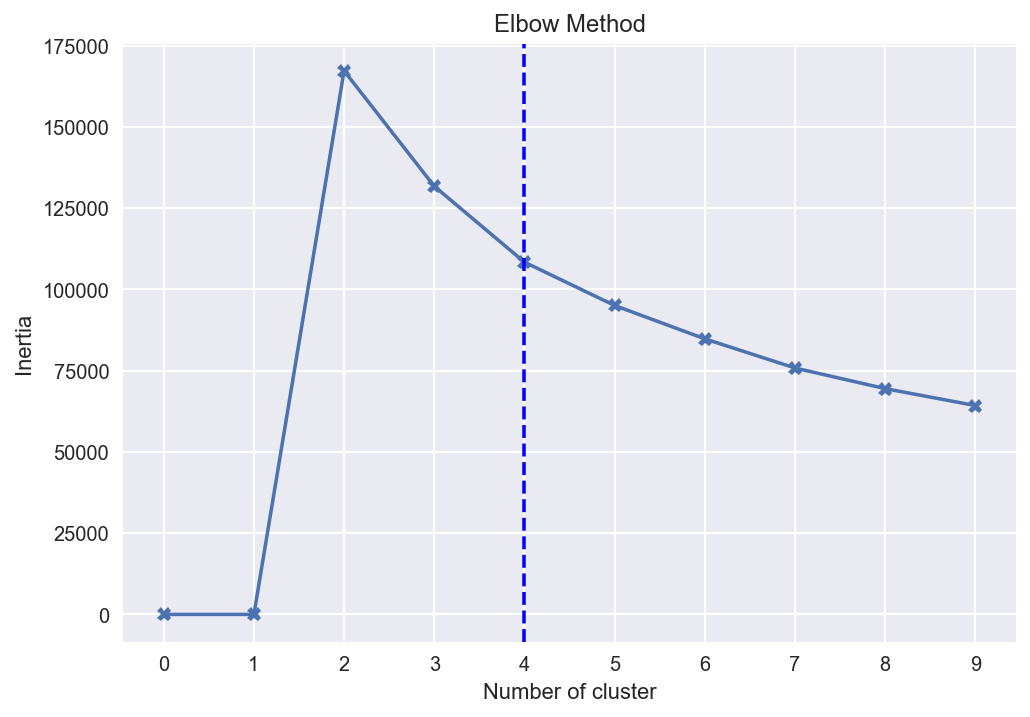

In [69]:
plt.plot(range(0, 10), inertia_list, "-X")

plt.title("Elbow Method")
plt.xticks(np.arange(10))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
# Draw vertical line in ax equal's 4
plt.axvline(x=4, color="blue", linestyle="--")

plt.savefig("../charts/Elbow_Method.png")
plt.show()


Results KMeans


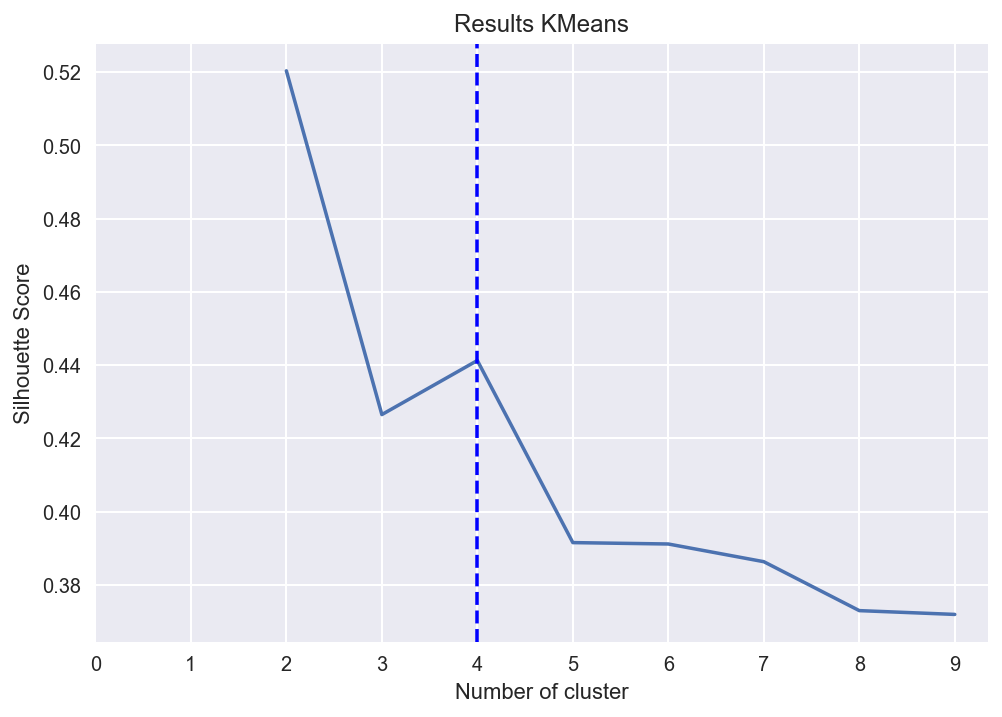

In [70]:
plt.plot(K, scores)

plt.title("Results KMeans")
plt.xticks(np.arange(10))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.axvline(x=4, color="blue", linestyle="--")

plt.savefig("../charts/Results_KMeans.png")
plt.show()


### K means clustering

Now that we have the number of clusters, we can use the KMeans algorithm.


In [71]:
clusterer = KMeans(n_clusters=4, random_state=30).fit(to_cluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(to_cluster)

centers


array([[ 1.6859081 , -1.67711621, -0.39729844],
       [-1.72324023,  0.12476707,  0.15343777],
       [ 8.06274357,  0.13311179,  1.11656004],
       [ 1.87270589,  2.52512675, -0.56430143]])

Data points in 3D PCA axis - clustered


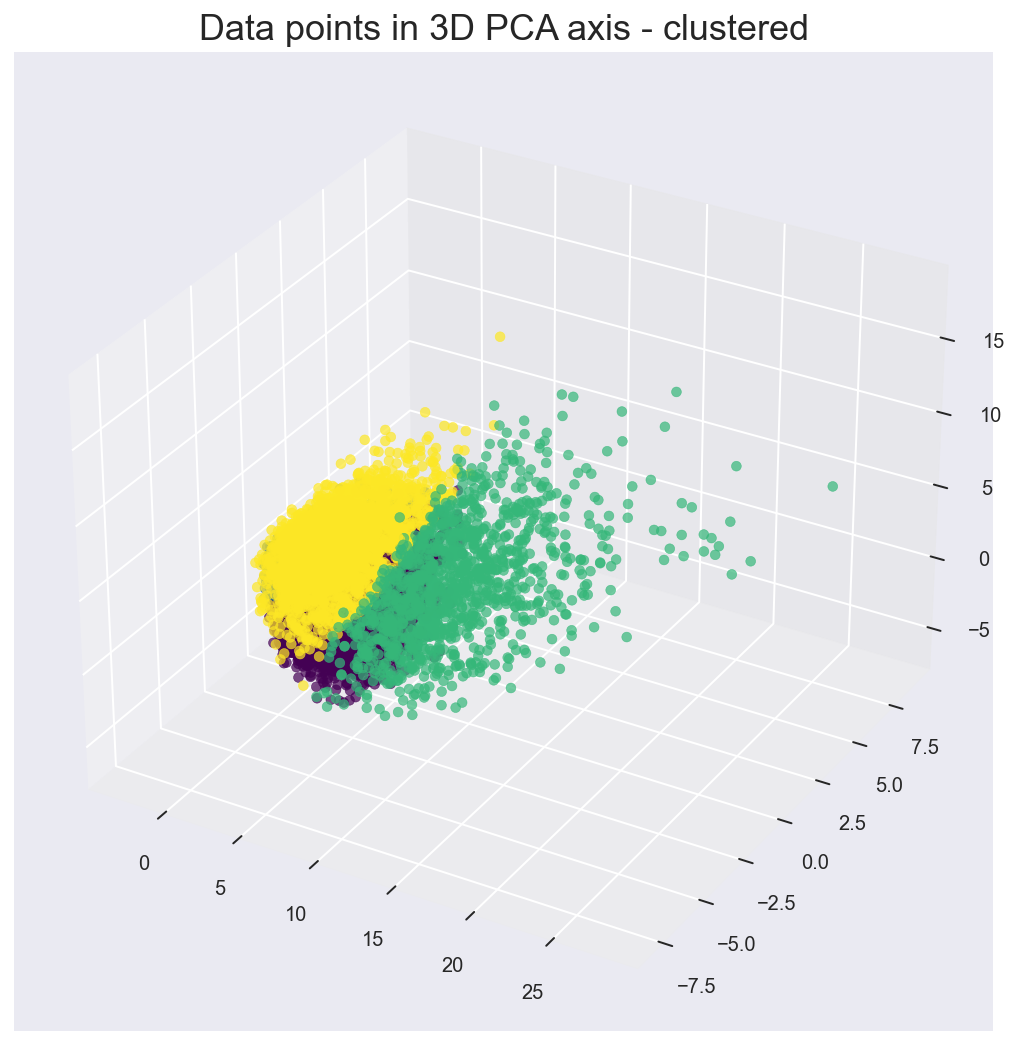

In [72]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    to_cluster[0],
    to_cluster[2],
    to_cluster[1],
    c=c_preds, # clusters
    cmap="viridis", # change color
    alpha=0.7, # Capacity
    s=24,
)

plt.title("Data points in 3D PCA axis - clustered", fontsize=18)
plt.savefig("../charts/Data_points_in_3D_PCA_axis_clustered.png")
plt.show()


Data points in 2D PCA axis - clustered


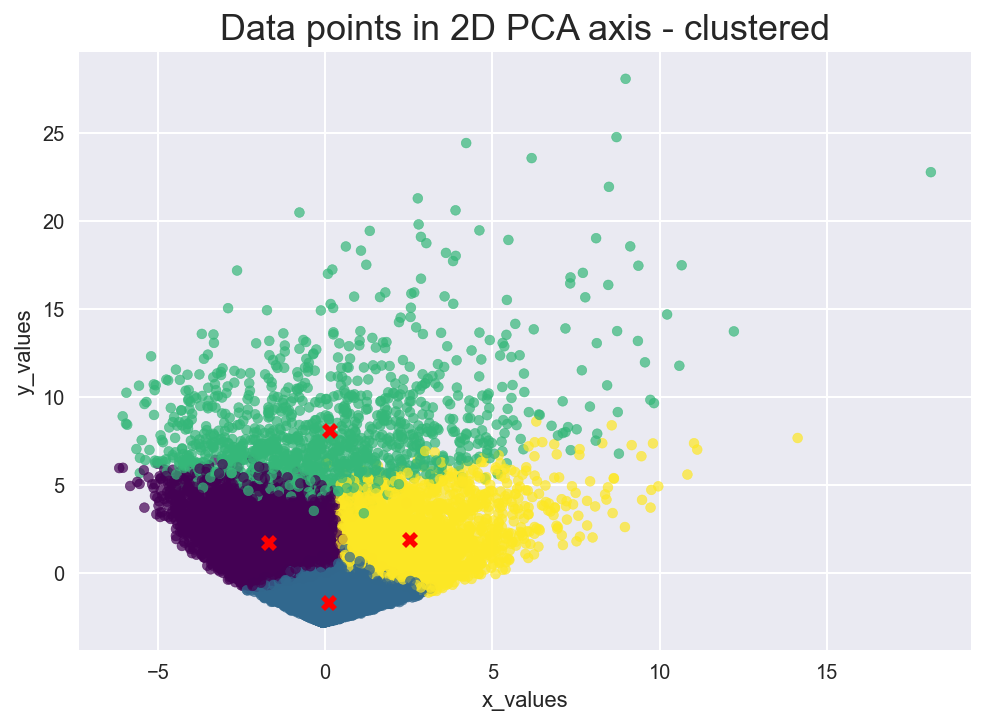

In [73]:
plt.scatter(to_cluster[1], to_cluster[0], c=c_preds, cmap="viridis", alpha=0.7, s=24)

for ci, c in enumerate(centers):
    plt.plot(c[1], c[0], "X", markersize=8, color="red", alpha=1)

plt.title("Data points in 2D PCA axis - clustered", fontsize=18)
plt.xlabel("x_values")
plt.ylabel("y_values")

plt.savefig("../charts/Data_points_in_2D_PCA_axis_clustered.png")
plt.show()


Add cluster to user_anime DataFrame


In [74]:
user_anime['cluster'] = c_preds
user_anime.head(10)


,"""0""","""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Calpis"" Hakkou Monogatari","""Eiji""","""Eiyuu"" Kaitai","""Kiss Dekiru Gyoza"" x Mameshiba Movie","""Parade"" de Satie","""R100"" x Mameshiba Original Manners",...,s.CRY.ed Alteration II: Quan,the FLY BanD!,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,ēlDLIVE,◯,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [75]:
user_anime.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21804 entries, 0 to 25000
Columns: 11410 entries, "0" to cluster
dtypes: int32(1), int64(11409)
memory usage: 1.9 GB


## Characteristic of Each Cluster
In this section, we will calculate information for each cluster and print statistical data.


In [76]:
c0 = user_anime[user_anime["cluster"] == 0].drop("cluster", axis=1).mean()
c1 = user_anime[user_anime["cluster"] == 1].drop("cluster", axis=1).mean()
c2 = user_anime[user_anime["cluster"] == 2].drop("cluster", axis=1).mean()
c3 = user_anime[user_anime["cluster"] == 3].drop("cluster", axis=1).mean()


### Functions


Create anime information list


In [77]:
def createAnimeInfoList(animelist):
    genre_list = list()
    episode_list = list()
    score_list = list()
    member_list = list()
    popularity_list = list()
    favorites_list = list()

    for x in anime["name"]:
        if x in animelist:
            for y in anime[anime["name"] == x].genres.values:
                genre_list.append(y)

            episode_list.append(anime[anime["name"] == x].episodes.values.astype(int))
            score_list.append(anime[anime["name"] == x].score.values.astype(float))
            member_list.append(anime[anime["name"] == x].members.values.astype(int))
            popularity_list.append(anime[anime["name"] == x].popularity.values.astype(int))
            favorites_list.append(anime[anime["name"] == x].favorites.values.astype(int))

    # Return data in pandas series form to prevent
    # "the Length of Values error does not match the length of the index"
    return (
        pd.Series(genre_list),
        pd.Series(episode_list),
        pd.Series(score_list),
        pd.Series(member_list),
        pd.Series(popularity_list),
        pd.Series(favorites_list),
    )


Count word


In [78]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste:
        keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split(","):
        if type(liste_keywords) == float and pd.isnull(liste_keywords):
            continue
        for s in [s for s in liste_keywords if s in liste]:
            if pd.notnull(s):
                keyword_count[s] += 1
    # ______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k, v in keyword_count.items():
        keyword_occurences.append([k, v])
    keyword_occurences.sort(key=lambda x: x[1], reverse=True)
    return keyword_occurences, keyword_count


Make cloud graph


In [79]:
def makeCloud(Dict, name, color, isSave=True):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
            width=1500,
            height=500,
            background_color=color,
            max_words=20,
            max_font_size=500,
            normalize_plurals=False,
        )
        wordcloud.generate_from_frequencies(words)

    fig = plt.figure(figsize=(20, 8))
    plt.title(name, fontsize=18)
    plt.imshow(wordcloud)
    plt.axis("off")

    if isSave:
        plt.savefig(f"../charts/{name}.png")
    plt.show()


### Calculate all genre keywords


In [80]:
animelist = list(c0.index)
data = pd.DataFrame()
data["genre"] = createAnimeInfoList(animelist)[0]


In [81]:
set_keywords = set()
for liste_keywords in data["genre"].str.split(",").values:
    if isinstance(liste_keywords, float):
        continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)


### Cluster 0


Top 15 anime which will explain characteristic of this cluster


In [120]:
c0.sort_values(ascending=False)[0:15]


Shingeki no Kyojin                       0.751535
One Punch Man                            0.732706
Kimi no Na wa.                           0.707532
Death Note                               0.640196
Koe no Katachi                           0.634056
Boku no Hero Academia 2nd Season         0.623823
No Game No Life                          0.622391
Re:Zero kara Hajimeru Isekai Seikatsu    0.615227
Fullmetal Alchemist: Brotherhood         0.614409
Boku no Hero Academia                    0.609906
Shingeki no Kyojin Season 2              0.609087
Steins;Gate                              0.591281
Shigatsu wa Kimi no Uso                  0.544003
Kimetsu no Yaiba                         0.543185
Boku dake ga Inai Machi                  0.528244
dtype: float64

Favorite genre for this cluster


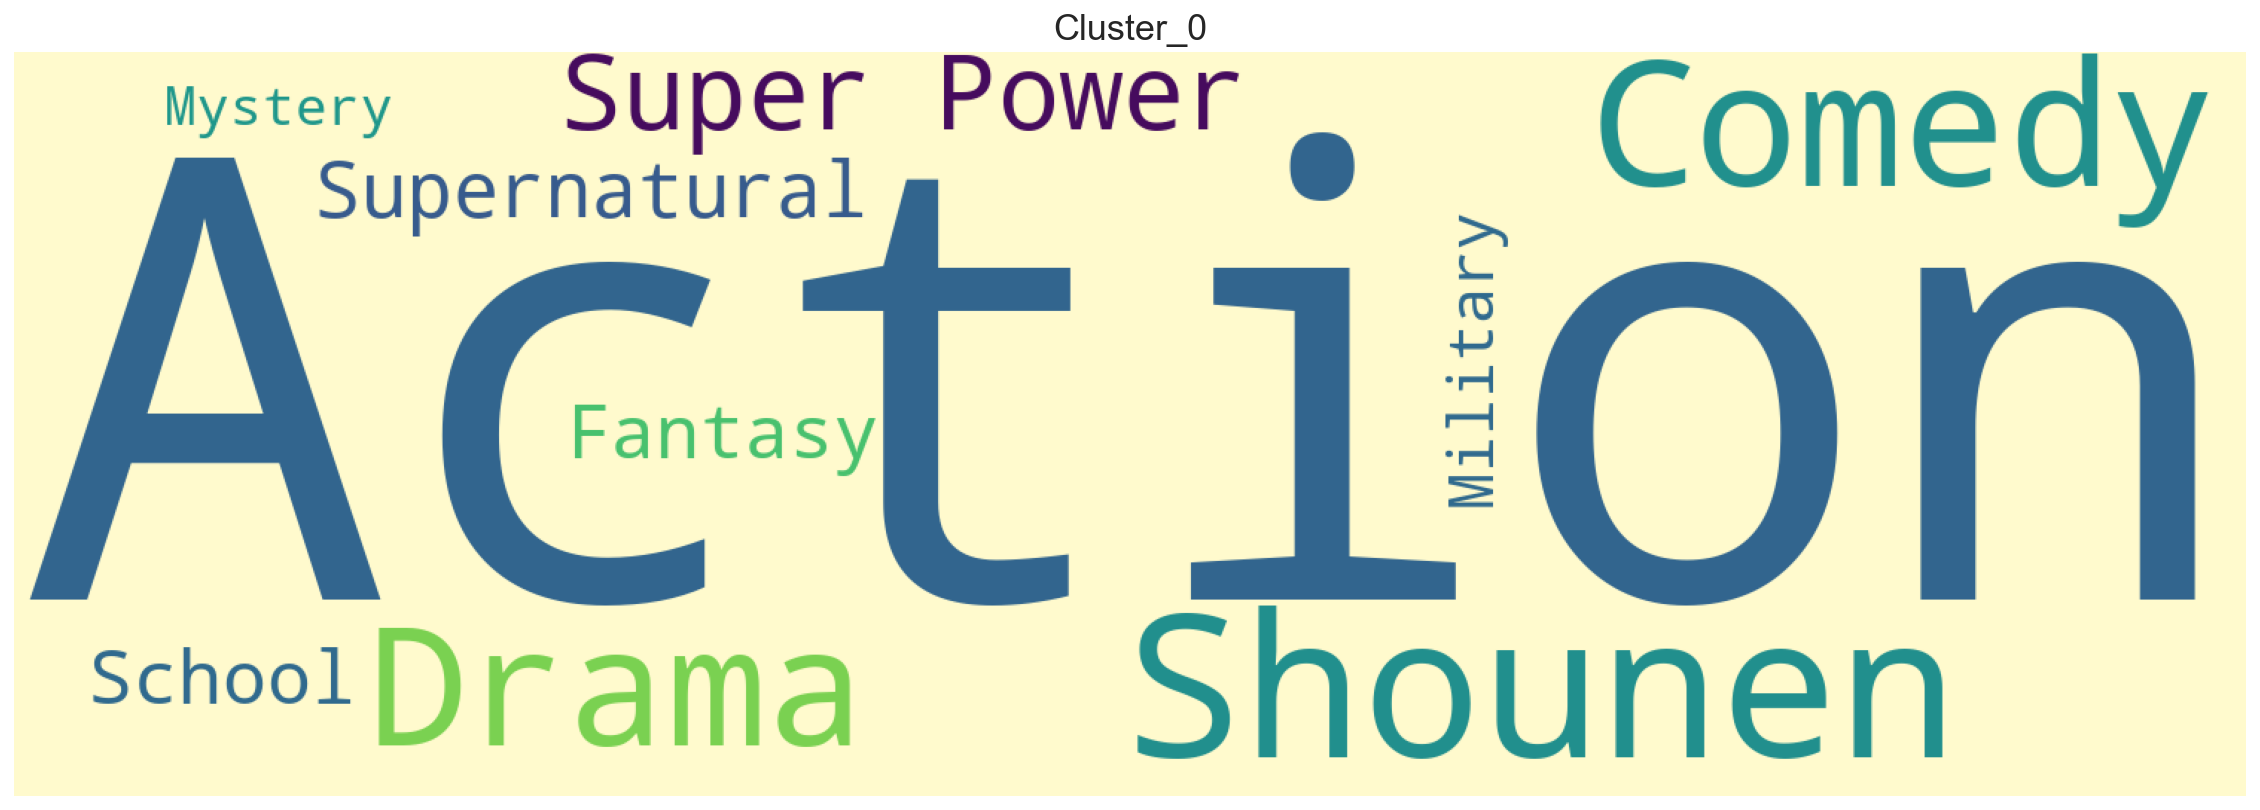

In [121]:
c0_animelist = list(c0.sort_values(ascending=False)[0:30].index)
c0_data = pd.DataFrame()
(
    c0_data["genre"],
    c0_data["episode"],
    c0_data["score"],
    c0_data["member"],
    c0_data["popularity"],
    c0_data["favorites"],
) = createAnimeInfoList(c0_animelist)

keyword_occurences, dum = count_word(c0_data, "genre", set_keywords)
makeCloud(keyword_occurences[0:10], "Cluster_0", "lemonchiffon")


In [122]:
keyword_occurences[0:5]


[['Action', 17],
 [' Shounen', 16],
 [' Comedy', 12],
 [' Drama', 11],
 [' Super Power', 11]]

Average of each information for anime which user in this cluster like


In [123]:
avg_episodes = int(c0_data["episode"].mean()[0].round())
avg_score = c0_data["score"].mean()[0].round(2)
avg_popularity = int(c0_data["popularity"].mean()[0].round())
avg_member = int(c0_data["member"].mean()[0].round())
avg_favorites = int(c0_data["favorites"].mean()[0].round())

print(f"Cluster 0\nAVG episode : {avg_episodes}\nAVG score : {avg_score}\nAVG popularity : {avg_popularity}\nAVG member : {avg_member}\nAVG favorites : {avg_favorites}\n")


Cluster 0
AVG episode : 23
AVG score : 8.55
AVG popularity : 25
AVG member : 1562339
AVG favorites : 59740



### Cluster 1


Top 15 anime which will explain characteristic of this cluster


In [124]:
c1.sort_values(ascending=False)[0:15]


Death Note                            0.371123
Shingeki no Kyojin                    0.265868
Fullmetal Alchemist: Brotherhood      0.251081
Sen to Chihiro no Kamikakushi         0.243270
Code Geass: Hangyaku no Lelouch       0.229013
Code Geass: Hangyaku no Lelouch R2    0.202017
Steins;Gate                           0.196557
Toradora!                             0.192386
One Punch Man                         0.187912
Kimi no Na wa.                        0.184652
Angel Beats!                          0.184197
Howl no Ugoku Shiro                   0.165314
Fullmetal Alchemist                   0.160158
Sword Art Online                      0.158641
Elfen Lied                            0.151513
dtype: float64

Favorite genre for this cluster


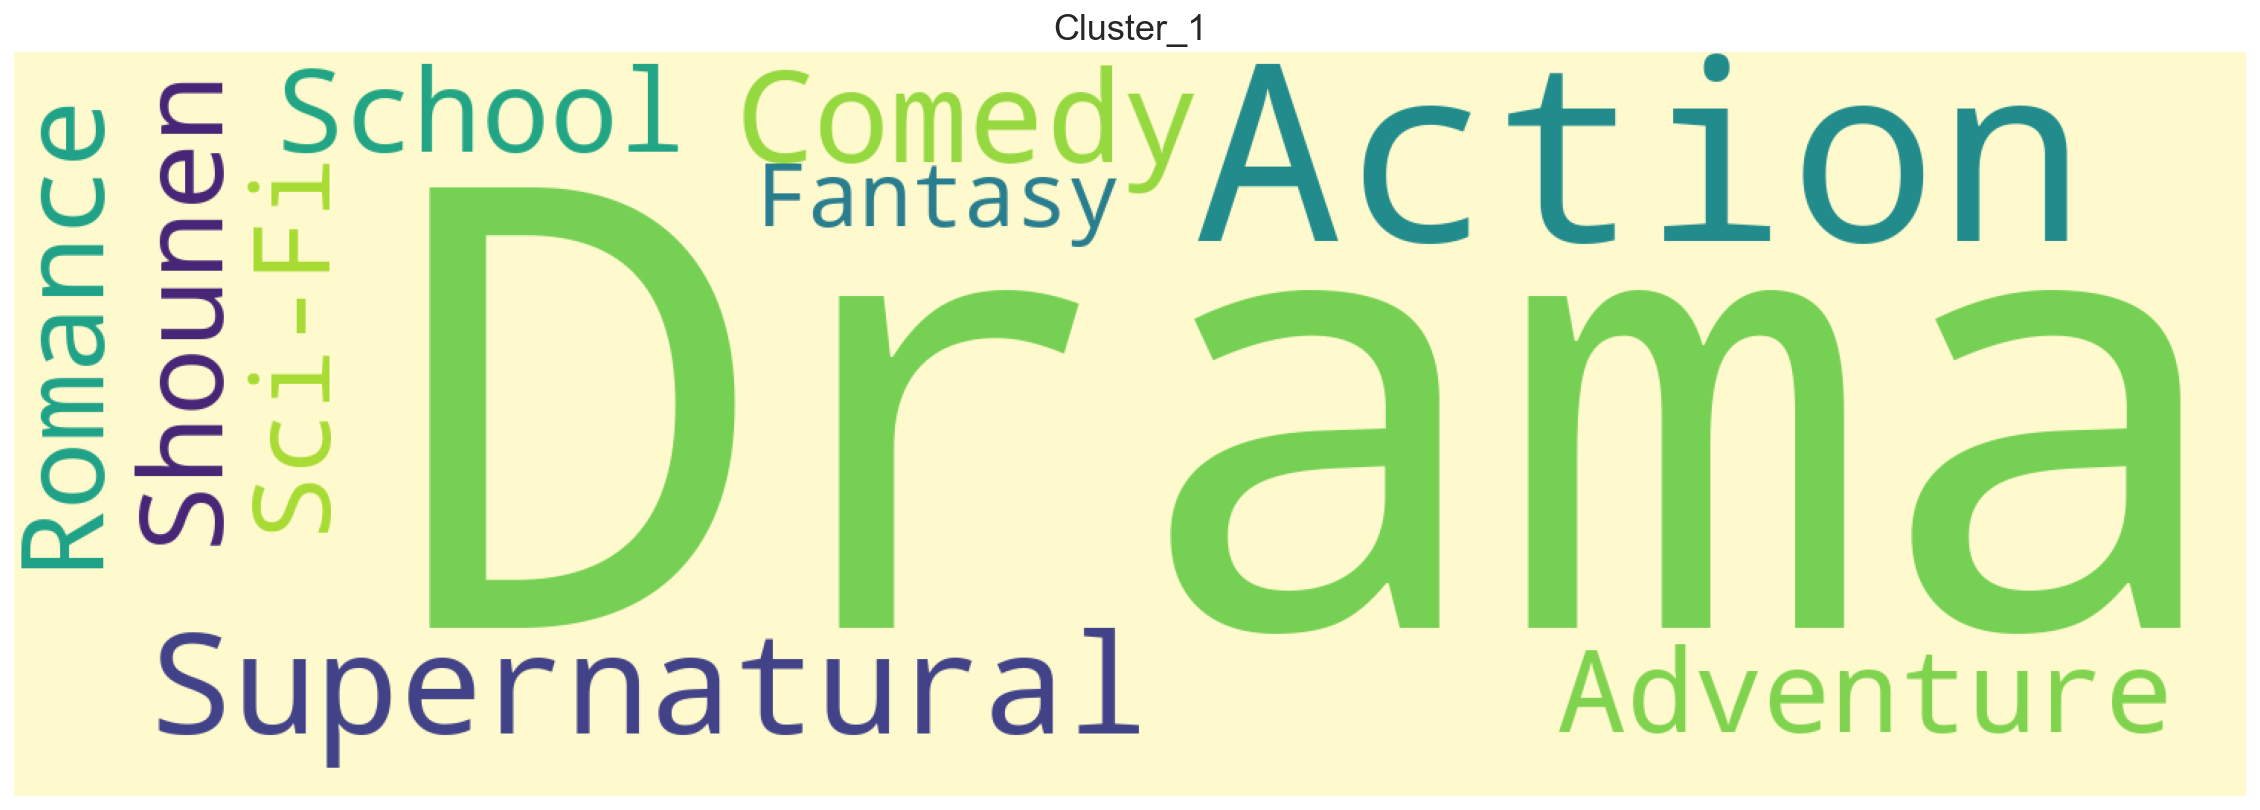

In [125]:
c1_animelist = list(c1.sort_values(ascending=False)[0:30].index)
c1_data = pd.DataFrame()
(
    c1_data["genre"],
    c1_data["episode"],
    c1_data["score"],
    c1_data["member"],
    c1_data["popularity"],
    c1_data["favorites"],
) = createAnimeInfoList(c1_animelist)

keyword_occurences, dum = count_word(c1_data, "genre", set_keywords)
makeCloud(keyword_occurences[0:10], "Cluster_1", "lemonchiffon")


In [126]:
keyword_occurences[0:5]


[[' Drama', 17],
 ['Action', 16],
 [' Supernatural', 12],
 [' Comedy', 10],
 [' Adventure', 8]]

Average of each information for anime which user in this cluster like


In [127]:
avg_episodes = int(c1_data["episode"].mean()[0].round())
avg_score = c1_data["score"].mean()[0].round(2)
avg_popularity = int(c1_data["popularity"].mean()[0].round())
avg_member = int(c1_data["member"].mean()[0].round())
avg_favorites = int(c1_data["favorites"].mean()[0].round())

print(f"Cluster 1\nAVG episode : {avg_episodes}\nAVG score : {avg_score}\nAVG popularity : {avg_popularity}\nAVG member : {avg_member}\nAVG favorites : {avg_favorites}\n")


Cluster 1
AVG episode : 27
AVG score : 8.44
AVG popularity : 35
AVG member : 1498743
AVG favorites : 62681



### Cluster 2


Top 15 anime which will explain characteristic of this cluster


In [128]:
c2.sort_values(ascending=False)[0:15]


No Game No Life                          0.863184
Shingeki no Kyojin                       0.846600
One Punch Man                            0.844942
Steins;Gate                              0.843284
Angel Beats!                             0.825871
Toradora!                                0.812604
Re:Zero kara Hajimeru Isekai Seikatsu    0.796849
Code Geass: Hangyaku no Lelouch          0.792703
Fullmetal Alchemist: Brotherhood         0.786070
Code Geass: Hangyaku no Lelouch R2       0.770315
Kimi no Na wa.                           0.764511
Death Note                               0.762852
Hataraku Maou-sama!                      0.762023
Boku dake ga Inai Machi                  0.758706
Shokugeki no Souma                       0.753731
dtype: float64

Favorite genre for this cluster


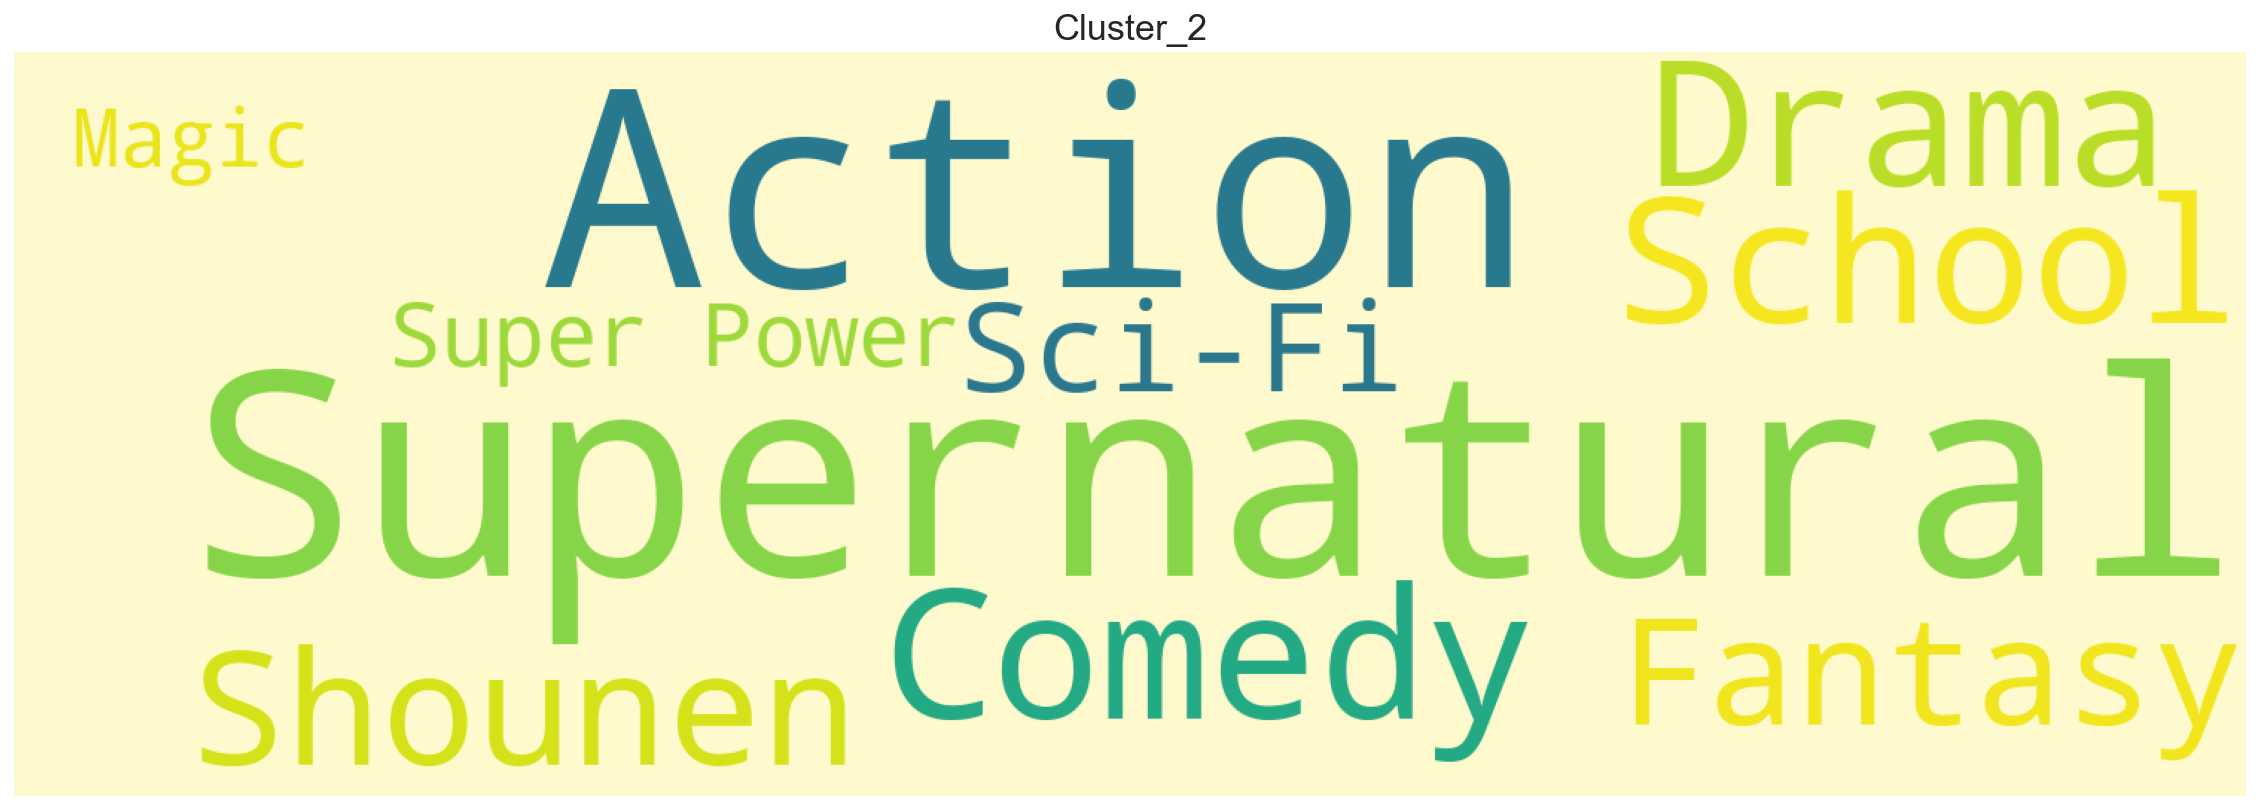

In [129]:
c2_animelist = list(c2.sort_values(ascending=False)[0:30].index)
c2_data = pd.DataFrame()
(
    c2_data["genre"],
    c2_data["episode"],
    c2_data["score"],
    c2_data["member"],
    c2_data["popularity"],
    c2_data["favorites"],
) = createAnimeInfoList(c2_animelist)

keyword_occurences, dum = count_word(c2_data, "genre", set_keywords)
makeCloud(keyword_occurences[0:10], "Cluster_2", "lemonchiffon")


In [130]:
keyword_occurences[0:5]


[[' Supernatural', 14],
 ['Action', 13],
 [' Comedy', 12],
 [' Drama', 11],
 [' School', 11]]

Average of each information for anime which user in this cluster like


In [131]:
avg_episodes = int(c2_data["episode"].mean()[0].round())
avg_score = c2_data["score"].mean()[0].round(2)
avg_popularity = int(c2_data["popularity"].mean()[0].round())
avg_member = int(c2_data["member"].mean()[0].round())
avg_favorites = int(c2_data["favorites"].mean()[0].round())

print(f"Cluster 2\nAVG episode : {avg_episodes}\nAVG score : {avg_score}\nAVG popularity : {avg_popularity}\nAVG member : {avg_member}\nAVG favorites : {avg_favorites}\n")


Cluster 2
AVG episode : 19
AVG score : 8.44
AVG popularity : 33
AVG member : 1481909
AVG favorites : 55440



### Cluster 3


Top 15 anime which will explain characteristic of this cluster


In [132]:
c3.sort_values(ascending=False)[0:15]


Code Geass: Hangyaku no Lelouch       0.692277
Death Note                            0.668911
Sen to Chihiro no Kamikakushi         0.659406
Fullmetal Alchemist: Brotherhood      0.651089
Code Geass: Hangyaku no Lelouch R2    0.629703
Steins;Gate                           0.627723
Tengen Toppa Gurren Lagann            0.584158
Toradora!                             0.580198
Bakemonogatari                        0.567129
Mononoke Hime                         0.560396
Shingeki no Kyojin                    0.544950
Suzumiya Haruhi no Yuuutsu            0.539802
Cowboy Bebop                          0.539406
Mahou Shoujo Madoka★Magica            0.538218
Toki wo Kakeru Shoujo                 0.535842
dtype: float64

Favorite genre for this cluster


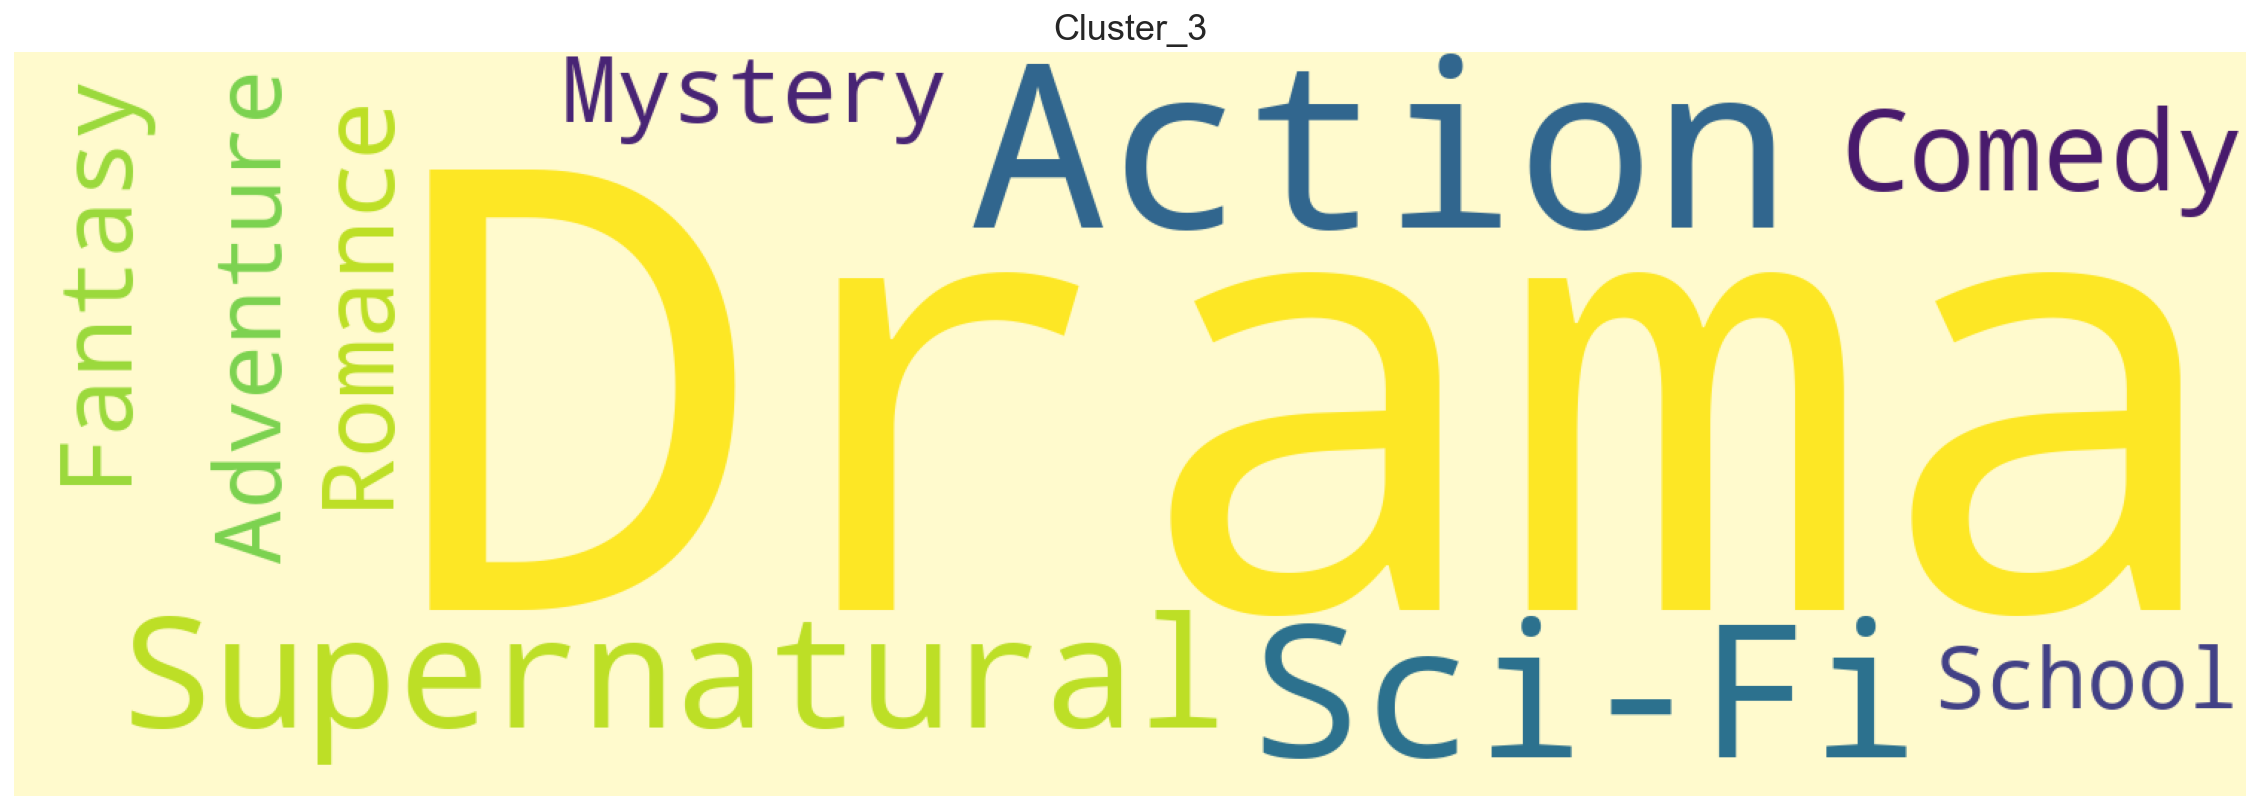

In [133]:
c3_animelist = list(c3.sort_values(ascending=False)[0:30].index)
c3_data = pd.DataFrame()
(
    c3_data["genre"],
    c3_data["episode"],
    c3_data["score"],
    c3_data["member"],
    c3_data["popularity"],
    c3_data["favorites"],
) = createAnimeInfoList(c3_animelist)

keyword_occurences, dum = count_word(c3_data, "genre", set_keywords)
makeCloud(keyword_occurences[0:10], "Cluster_3", "lemonchiffon")


In [134]:
keyword_occurences[0:5]


[[' Drama', 16],
 ['Action', 16],
 [' Sci-Fi', 10],
 [' Supernatural', 10],
 [' Comedy', 9]]

Average of each information for anime which user in this cluster like


In [135]:
avg_episodes = int(c3_data["episode"].mean()[0].round())
avg_score = c3_data["score"].mean()[0].round(2)
avg_popularity = int(c3_data["popularity"].mean()[0].round())
avg_member = int(c3_data["member"].mean()[0].round())
avg_favorites = int(c3_data["favorites"].mean()[0].round())

print(f"Cluster 3\nAVG episode : {avg_episodes}\nAVG score : {avg_score}\nAVG popularity : {avg_popularity}\nAVG member : {avg_member}\nAVG favorites : {avg_favorites}\n")


Cluster 3
AVG episode : 21
AVG score : 8.48
AVG popularity : 66
AVG member : 1214717
AVG favorites : 52597



![The End](https://www.gladstonebrookes.co.uk/wp-content/uploads/2019/08/News-Gladstone-Brookes-PPI-%E2%80%93-The-Beginning-of-the-End-29th-August-2019.png)
